### VentureLab Assignments

1. Describe the dataset, identify data quality issues and how you handled them.
2. Perform an exploratory analysis to answer:
- Which metrics would you use to define a high-value player?
- Are there meaningful differences between brands or affiliates?
3. Design a player segmentation:
- Explain which features you selected and why
- Choose any approach you consider appropriate
- Interpret the resulting segments

4. Modeling Task (choose one)
- **Option A — Forecasting: Forecast monthly deposits At brand level or globally**
    - Describe assumptions, limitations, and uncertainty

- Option B — Player Value / LTV Proxy
   - Build a proxy for player value or LTV
   - Focus on reasoning, feature selection, and robustness rather than absolute accuracy

- Option C — Churn
    - Define churn or inactivity
    - Identify early signals of churn
    - Propose actionable insights

5. Describe how you would implement your solution in a real production environment.

6. Conclusions & Recommendations:
- Summarize key findings and insights
- Propose business actions based on your analysis
- Describe what you would improve with more time or additional data
- Other than that feel free to express yourself and showcase your abilities.
- Prepare your findings as if you were presenting them to a non-technical senior stakeholder.

In [1]:
# loading modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

import statsmodels.api as sm
import xgboost as xgb
from xgboost import XGBRegressor
import optuna
import shap

In [2]:
# Loading dataset
data = pd.read_csv('data/Assessment Data.csv')
data

,date,brand,user_id,user_affiliate_id,new_registration,first_time_deposit,deposit_amount,withdraw_amount,casino_bet_amount,casino_win_amount,sports_bet_amount,sports_win_amount
0,01/01/2022,L,241628,69,0,0,0.000000,0.0,2662.8,2112.8,0.0,0.0
1,01/01/2022,L,288644,143,0,0,2.681123,0.0,19044.0,16363.9,0.0,0.0
2,01/01/2022,L,291489,NaN,0,0,0.000000,0.0,11354.0,11013.4,300.0,0.0
3,01/01/2022,L,320100,NaN,0,0,26.010894,0.0,279710.0,347362.0,0.0,0.0
4,01/01/2022,L,320872,143,0,0,0.000000,0.0,585.0,486.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
373930,31/03/2024,S,1176737,180,1,0,0.000000,0.0,0.0,0.0,0.0,0.0
373931,31/03/2024,S,1176741,"Error, Token contains the affiliate ID whom d...",1,0,0.000000,0.0,0.0,0.0,0.0,0.0
373932,31/03/2024,S,1176767,180,1,0,0.000000,0.0,0.0,0.0,0.0,0.0
373933,31/03/2024,S,1176841,134,1,1,0.102733,0.0,0.0,0.0,24.7,14.7


### Task 1 — Dataset description & Data Quality

#### What I check (typical iGaming daily activity data)
**Schema & types**
- `date` parseability and consistency (dayfirst format)
- numeric columns are truly numeric (no strings like "Error, Token contains...")
- flags (`new_registration`, `first_time_deposit`) are 0/1

**Completeness**
- missing `user_id`, `brand`, `date` (critical keys)
- missing affiliate (allowed; treat as Unknown / -1)

**Duplicates**
- exact duplicate rows
- duplicate keys (e.g., same `date, brand, user_id` repeated) which can inflate sums
  - decide: either drop exact duplicates OR aggregate duplicates by summing numeric activity

**Validity / ranges**
- amounts should be >= 0
- wins can be 0; (wins > bets can occur per day due to payout timing, but monitor)

**Consistency**
- `first_time_deposit = 1` should imply `deposit_amount > 0` on that day (usually)
- `new_registration = 1` should occur at most once per user per brand (unless data is per-operator global)


In [3]:
df = data.copy()
df.columns = df.columns.str.strip().str.lower()

# Parse date: sample shows "01/01/2022" -> dayfirst=True
df["date"] = pd.to_datetime(df["date"], dayfirst=True, errors="coerce")

# Quick schema view
print(df.dtypes)


date                  datetime64[ns]
brand                         object
user_id                        int64
user_affiliate_id             object
new_registration               int64
first_time_deposit             int64
deposit_amount               float64
withdraw_amount              float64
casino_bet_amount            float64
casino_win_amount            float64
sports_bet_amount            float64
sports_win_amount            float64
dtype: object


In [4]:
# user_affiliate_id should be int, but keep original and
# change to numeric

df["user_affiliate_id_raw"] = df["user_affiliate_id"]
df["user_affiliate_id"] = pd.to_numeric(df["user_affiliate_id"], errors="coerce")

In [5]:
# data quality check

def data_quality_report(d: pd.DataFrame) -> pd.DataFrame:
    report = []
    n = len(d)

    def add(metric, value):
        report.append({"metric": metric, "value": value})

    add("rows", n)
    add("distinct_users", d["user_id"].nunique(dropna=True))
    add("distinct_brands", d["brand"].nunique(dropna=True))
    add("date_min", d["date"].min())
    add("date_max", d["date"].max())

    # Missing critical keys
    add("missing_date", d["date"].isna().sum())
    add("missing_brand", d["brand"].isna().sum())
    add("missing_user_id", d["user_id"].isna().sum())

    # Affiliate issues
    add("affiliate_non_numeric_or_missing", d["user_affiliate_id"].isna().sum())

    # Exact duplicates (all columns)
    add("exact_duplicate_rows", d.duplicated().sum())

    # Potential key duplicates: same date-brand-user appears more than once
    key = ["date", "brand", "user_id"]
    add("dup_key_date_brand_user", d.duplicated(subset=key).sum())

    # Negative values check (should be none)
    for c in ["deposit_amount","withdraw_amount","casino_bet_amount","casino_win_amount","sports_bet_amount","sports_win_amount"]:
        add(f"negative_{c}", (d[c] < 0).sum())

    # Flag validity
    for c in ["new_registration","first_time_deposit"]:
        add(f"invalid_flag_{c}", (~d[c].isin([0,1]) & d[c].notna()).sum())

    return pd.DataFrame(report)

dq = data_quality_report(df)
dq


,metric,value
0,rows,373935
1,distinct_users,26845
2,distinct_brands,3
3,date_min,2022-01-01 00:00:00
4,date_max,2024-03-31 00:00:00
5,missing_date,0
6,missing_brand,0
7,missing_user_id,0
8,affiliate_non_numeric_or_missing,149043
9,exact_duplicate_rows,0


In [6]:
raw = df["user_affiliate_id_raw"]
missing = raw.isna().sum()
non_numeric = raw.notna().sum() - pd.to_numeric(raw, errors="coerce").notna().sum()

print("missing affiliate:", missing)
print("non-numeric affiliate (errors/codes):", non_numeric)

# look at top bad strings
bad = raw[pd.to_numeric(raw, errors="coerce").isna() & raw.notna()]
print(bad.value_counts().head(10))


missing affiliate: 145635
non-numeric affiliate (errors/codes): 3408
user_affiliate_id_raw
Error, Token contains the affiliate ID  whom does not exist        2477
Error, Token contains the affiliate ID 1053 whom does not exist     222
Error, Token contains the affiliate ID 1049 whom does not exist     206
Error, Token contains the affiliate ID 1042 whom does not exist     110
Error, Token contains the affiliate ID 1321 whom does not exist      92
Error, Token contains the affiliate ID 917 whom does not exist       86
Error, Token contains the affiliate ID 958 whom does not exist       74
Error, Token contains the affiliate ID 912 whom does not exist       59
Error, Token contains the affiliate ID 1031 whom does not exist      43
Error, Token contains the affiliate ID 1041 whom does not exist      18
Name: count, dtype: int64


In [7]:
df["affiliate_id"] = pd.to_numeric(raw, errors="coerce").astype("Int64")  # allows <NA>

df["affiliate_group"] = np.where(
    df["affiliate_id"].notna(),
    df["affiliate_id"].astype(str),   # safe; <NA> stays <NA> but we don't use it
    np.where(raw.isna(), "UNKNOWN_MISSING", "UNKNOWN_ERROR")
)

df

,date,brand,user_id,user_affiliate_id,new_registration,first_time_deposit,deposit_amount,withdraw_amount,casino_bet_amount,casino_win_amount,sports_bet_amount,sports_win_amount,user_affiliate_id_raw,affiliate_id,affiliate_group
0,2022-01-01,L,241628,69.0,0,0,0.000000,0.0,2662.8,2112.8,0.0,0.0,69,69,69
1,2022-01-01,L,288644,143.0,0,0,2.681123,0.0,19044.0,16363.9,0.0,0.0,143,143,143
2,2022-01-01,L,291489,NaN,0,0,0.000000,0.0,11354.0,11013.4,300.0,0.0,NaN,<NA>,UNKNOWN_MISSING
3,2022-01-01,L,320100,NaN,0,0,26.010894,0.0,279710.0,347362.0,0.0,0.0,NaN,<NA>,UNKNOWN_MISSING
4,2022-01-01,L,320872,143.0,0,0,0.000000,0.0,585.0,486.0,0.0,0.0,143,143,143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373930,2024-03-31,S,1176737,180.0,1,0,0.000000,0.0,0.0,0.0,0.0,0.0,180,180,180
373931,2024-03-31,S,1176741,NaN,1,0,0.000000,0.0,0.0,0.0,0.0,0.0,"Error, Token contains the affiliate ID whom d...",<NA>,UNKNOWN_ERROR
373932,2024-03-31,S,1176767,180.0,1,0,0.000000,0.0,0.0,0.0,0.0,0.0,180,180,180
373933,2024-03-31,S,1176841,134.0,1,1,0.102733,0.0,0.0,0.0,24.7,14.7,134,134,134


In [8]:
# Code cell — cleaning decisions (drop bad keys, fix negatives, handle duplicates)
# 1) Drop rows with missing critical keys
df = df.dropna(subset=["date", "brand", "user_id"]).copy()

# Ensure user_id is integer-like
df["user_id"] = pd.to_numeric(df["user_id"], errors="coerce")
df = df.dropna(subset=["user_id"]).copy()
df["user_id"] = df["user_id"].astype("int64")

# 2) Fix negative values (if any) by clipping to 0
AMOUNT_COLS = ["deposit_amount","withdraw_amount","casino_bet_amount","casino_win_amount","sports_bet_amount","sports_win_amount"]
for c in AMOUNT_COLS:
    df[c] = df[c].fillna(0).clip(lower=0)

# 3) Normalize flags to 0/1 (anything else -> 0, and keep an audit column if needed)
for c in ["new_registration","first_time_deposit"]:
    df[c] = df[c].fillna(0)
    df[c] = np.where(df[c].isin([0,1]), df[c], 0).astype(int)

# 4) Decide how to handle duplicate (date, brand, user) rows:
#    In iGaming data, duplicates often mean multiple events collapsed incorrectly.
#    A robust approach is to aggregate duplicates by summing numeric activity.
KEY = ["date", "brand", "user_id"]
AGG_MAP = {c: "sum" for c in AMOUNT_COLS + ["new_registration","first_time_deposit"]}
AGG_MAP["user_affiliate_id"] = "max"  # keep any numeric affiliate id if present
AGG_MAP["user_affiliate_id_raw"] = "last"  # keep latest raw text (audit)

df = df.groupby(KEY, as_index=False).agg(AGG_MAP)

dq_after = data_quality_report(df)
dq_after


,metric,value
0,rows,373935
1,distinct_users,26845
2,distinct_brands,3
3,date_min,2022-01-01 00:00:00
4,date_max,2024-03-31 00:00:00
5,missing_date,0
6,missing_brand,0
7,missing_user_id,0
8,affiliate_non_numeric_or_missing,149043
9,exact_duplicate_rows,0


### Answer 1 — Dataset description & data quality

#### Dataset overview
- **Grain:** 1 row per **day × brand × user** (daily player activity)
- **Rows:** 373,935
- **Unique users:** 26,845
- **Brands:** 3
- **Time range:** 2022-01-01 -> 2024-03-31
- **Main fields:**
  - acquisition: `user_affiliate_id`, `new_registration`, `first_time_deposit`
  - cashflow: `deposit_amount`, `withdraw_amount`
  - gameplay: `casino_bet_amount`, `casino_win_amount`, `sports_bet_amount`, `sports_win_amount`

### Data quality issues found
1) **Affiliate ID quality**
- Large portion of rows have **missing affiliate attribution** (~145,635) → likely organic/direct or tracking not captured.
- Additional rows have **invalid affiliate tokens** (~3,408) containing error strings like “affiliate ID … does not exist”.
- Handling:
  - coerced `user_affiliate_id` to numeric where possible
  - mapped non-numeric/missing values into a safe bucket (e.g., `UNKNOWN`) for grouping and reporting
  - (optional) kept the raw affiliate text for audit/debug purposes

2) **Negative monetary values**
- Detected a small number of negative values:
  - `casino_bet_amount`: 14 rows
  - `sports_win_amount`: 7 rows
- These are not meaningful as “amounts” in standard reporting (often correction artifacts).
- Handling:
  - clipped negative monetary values to **0** to prevent invalid aggregates and misleading KPIs
  - (optionally) retained the set of affected rows for traceability

3) **Duplicates / key integrity**
- Checked for exact duplicates and duplicate keys (`date, brand, user_id`).
- Result: **no duplicates detected** in this dataset snapshot.
- Handling:
  - implemented a robust deduplication strategy anyway: if duplicates appear in future data, rows are aggregated by `(date, brand, user_id)` summing activity fields to avoid double counting.

4) **Critical missing keys and type consistency**
- Verified `date`, `brand`, and `user_id` are complete (no missing values).
- Parsed `date` into a proper date type.
- Ensured `user_id` is numeric and consistent.
- Normalized binary flags (`new_registration`, `first_time_deposit`) to valid 0/1 values.

#### Resulting cleaned dataset
After cleaning:
- The dataset maintains the same grain (daily player activity per brand)
- Monetary and activity fields are valid for aggregation (no negative amounts)
- Affiliate attribution is usable for KPI splits (numeric IDs + `UNKNOWN` bucket)
- The dataset is ready for EDA, segmentation, and modeling tasks (forecasting / churn / LTV proxy).


---

### Task 2 — Exploratory analysis

#### High-value player (business definition)
In iGaming, "high value" is typically not just deposits:
- **Monetary**
  - Total deposits (cash-in)
  - Net deposits (deposits - withdrawals)
  - **Total GGR** (bets - wins) as a proxy for operator revenue contribution
- **Engagement**
  - Active days (how often they play)
  - Recency (how recently they were active)
  - Frequency (days/week or active ratio)
- **Product mix**
  - Casino vs Sports share (different behaviors and margins)
- **Lifecycle**
  - First-time deposit (FTD) vs returning
  - Tenure (days between first and last activity)

#### Brand / Affiliate differences
Compare:
- deposits/user, GGR/user, active days/user
- FTD rates
- retention/recency patterns (if churn is chosen later)


In [9]:
# Cashflow style metrics
df["net_deposit"] = df["deposit_amount"] - df["withdraw_amount"]

# Gaming margin proxies (GGR = bets - wins)
df["casino_ggr"] = df["casino_bet_amount"] - df["casino_win_amount"]
df["sports_ggr"] = df["sports_bet_amount"] - df["sports_win_amount"]
df["total_ggr"]  = df["casino_ggr"] + df["sports_ggr"]

# Activity flags
df["active_any"] = (
    (df["deposit_amount"] > 0) |
    (df["withdraw_amount"] > 0) |
    (df["casino_bet_amount"] > 0) |
    (df["sports_bet_amount"] > 0)
).astype(int)

df.head()


,date,brand,user_id,deposit_amount,withdraw_amount,casino_bet_amount,casino_win_amount,sports_bet_amount,sports_win_amount,new_registration,first_time_deposit,user_affiliate_id,user_affiliate_id_raw,net_deposit,casino_ggr,sports_ggr,total_ggr,active_any
0,2022-01-01,L,241628,0.000000,0.0,2662.8,2112.8,0.0,0.0,0,0,69.0,69,0.000000,550.0,0.0,550.0,1
1,2022-01-01,L,288644,2.681123,0.0,19044.0,16363.9,0.0,0.0,0,0,143.0,143,2.681123,2680.1,0.0,2680.1,1
2,2022-01-01,L,291489,0.000000,0.0,11354.0,11013.4,300.0,0.0,0,0,NaN,None,0.000000,340.6,300.0,640.6,1
3,2022-01-01,L,320100,26.010894,0.0,279710.0,347362.0,0.0,0.0,0,0,NaN,None,26.010894,-67652.0,0.0,-67652.0,1
4,2022-01-01,L,320872,0.000000,0.0,585.0,486.0,0.0,0.0,0,0,143.0,143,0.000000,99.0,0.0,99.0,1


In [10]:
# player-level KPIs
player_kpi = (df.groupby("user_id", as_index=False)
             .agg(
                 active_days=("active_any","sum"),
                 total_deposit=("deposit_amount","sum"),
                 total_withdraw=("withdraw_amount","sum"),
                 net_deposit=("net_deposit","sum"),
                 total_ggr=("total_ggr","sum"),
                 first_date=("date","min"),
                 last_date=("date","max"),
             ))


In [11]:
# brand-level differences
brand_kpi = (df.groupby("brand", as_index=False)
             .agg(
                 users=("user_id","nunique"),
                 deposits=("deposit_amount","sum"),
                 ggr=("total_ggr","sum"),
                 active_days=("active_any","sum")
             ))
brand_kpi["deposit_per_user"] = brand_kpi["deposits"]/brand_kpi["users"]
brand_kpi["ggr_per_user"] = brand_kpi["ggr"]/brand_kpi["users"]
brand_kpi


,brand,users,deposits,ggr,active_days,deposit_per_user,ggr_per_user
0,J,986,2677.226482,1.935410e+03,2079,2.71524,1.962890
1,L,14404,321807.392528,2.014848e+08,307143,22.34153,13988.115606
2,S,11455,59137.581046,4.626423e+06,27659,5.16260,403.878046


In [12]:
# Player-level aggregation (across whole dataset)
player = (df
          .groupby(["user_id"], as_index=False)
          .agg(
              first_date=("date","min"),
              last_date=("date","max"),
              active_days=("active_any","sum"),
              total_deposit=("deposit_amount","sum"),
              total_withdraw=("withdraw_amount","sum"),
              net_deposit=("net_deposit","sum"),
              casino_bet=("casino_bet_amount","sum"),
              sports_bet=("sports_bet_amount","sum"),
              casino_ggr=("casino_ggr","sum"),
              sports_ggr=("sports_ggr","sum"),
              total_ggr=("total_ggr","sum"),
              any_ftd=("first_time_deposit","max"),
          ))

asof = df["date"].max()
player["tenure_days"] = (player["last_date"] - player["first_date"]).dt.days.clip(lower=0)
player["recency_days"] = (asof - player["last_date"]).dt.days.clip(lower=0)

# Mix
player["total_bet"] = player["casino_bet"] + player["sports_bet"]
player["casino_share"] = np.where(player["total_bet"] > 0, player["casino_bet"]/player["total_bet"], 0.0)

player.head()


,user_id,first_date,last_date,active_days,total_deposit,total_withdraw,net_deposit,casino_bet,sports_bet,casino_ggr,sports_ggr,total_ggr,any_ftd,tenure_days,recency_days,total_bet,casino_share
0,33178,2023-07-13,2023-09-22,7,1.030000,2.140000,-1.110000,0.0,0.0,0.0,0.0,0.0,1,71,191,0.0,0.0
1,34769,2023-10-13,2023-12-02,0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0,50,120,0.0,0.0
2,74056,2023-07-24,2023-07-24,0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0,0,251,0.0,0.0
3,236255,2022-05-15,2024-03-16,24,3.407373,1.460063,1.947310,41712.7,0.0,4144.8,0.0,4144.8,0,671,15,41712.7,1.0
4,236537,2022-06-10,2022-11-07,22,5.176922,8.845989,-3.669067,43066.8,0.0,-2736.3,0.0,-2736.3,0,150,510,43066.8,1.0


In [13]:
# robust standardized score: where a player sits relative to the median 
# and spread (IQR) of the population, which is often better for iGaming 
# because deposits/GGR are heavy-tailed.
    
def robust_z(x):
    med = np.nanmedian(x)
    iqr = np.nanpercentile(x, 75) - np.nanpercentile(x, 25)
    return (x - med) / (iqr if iqr != 0 else 1.0)

player["score_deposit"] = robust_z(player["total_deposit"])
player["score_ggr"]     = robust_z(player["total_ggr"])
player["score_active"]  = robust_z(player["active_days"])
player["score_recency"] = -robust_z(player["recency_days"])

player["high_value_score"] = (
    0.35*player["score_deposit"] +
    0.35*player["score_ggr"] +
    0.20*player["score_active"] +
    0.10*player["score_recency"]
)

player.sort_values("high_value_score", ascending=False).head(10)


,user_id,first_date,last_date,active_days,total_deposit,total_withdraw,net_deposit,casino_bet,sports_bet,casino_ggr,...,any_ftd,tenure_days,recency_days,total_bet,casino_share,score_deposit,score_ggr,score_active,score_recency,high_value_score
1713,487451,2022-01-03,2024-03-29,446,4805.914274,1093.039099,3712.875175,60682310.02,0.00,4833889.23,...,0,816,2,60682310.02,1.000000,1601.881886,4833.88923,74.166667,0.512195,2267.404444
6508,721881,2022-07-12,2024-03-30,142,3742.044949,892.344660,2849.700289,93186057.49,190553.29,3728876.49,...,1,627,1,93376610.78,0.997959,1247.258778,3663.24000,23.500000,0.515244,1723.426097
16509,970202,2023-08-11,2024-03-31,157,10748.419849,0.000000,10748.419849,0.00,14687108.45,0.00,...,1,233,0,14687108.45,0.000000,3582.717078,1312.06573,26.000000,0.518293,1718.425812
395,361918,2022-05-31,2024-02-01,255,8853.920334,1468.801990,7385.118344,32451805.11,10.00,1241758.68,...,0,611,59,32451815.11,1.000000,2951.217240,1241.71918,42.333333,0.338415,1476.028255
327,320979,2022-01-02,2023-10-30,286,4849.161111,3637.472343,1211.688768,48995997.43,18360.08,2025523.35,...,0,666,153,49014357.51,0.999625,1616.297499,2030.90851,47.500000,0.051829,1286.027286
3993,589411,2022-01-01,2024-03-31,450,2181.253961,237.028963,1944.224998,1524053.00,17021092.22,134562.25,...,0,820,0,18545145.22,0.082181,726.995115,2832.14306,74.833333,0.518293,1260.716857
1975,494860,2022-01-10,2024-03-27,416,2105.601203,51.985046,2053.616157,49309632.30,250.00,2614617.32,...,0,807,4,49309882.30,0.999995,701.777529,2614.77643,69.166667,0.506098,1174.677829
6316,710103,2022-05-24,2024-03-30,158,1932.397811,140.839871,1791.557940,26841723.61,144408.00,2054410.58,...,1,676,1,26986131.61,0.994649,644.043065,2074.11930,26.166667,0.515244,956.641686
316,320100,2022-01-01,2024-02-20,243,2779.998692,1549.210622,1230.788070,30392744.32,0.00,1710780.27,...,0,780,40,30392744.32,1.000000,926.576692,1710.78027,40.333333,0.396341,931.181238
1819,491056,2022-01-01,2022-11-24,325,2517.952415,925.429565,1592.522850,56315849.65,0.00,1729752.18,...,0,327,493,56315849.65,1.000000,839.227933,1729.75218,54.000000,-0.984756,909.844564


In [14]:
brand_kpi = (df.groupby("brand", as_index=False)
             .agg(
                 users=("user_id","nunique"),
                 days=("date","nunique"),
                 deposits=("deposit_amount","sum"),
                 withdrawals=("withdraw_amount","sum"),
                 net_deposit=("net_deposit","sum"),
                 ggr=("total_ggr","sum"),
                 active_days=("active_any","sum"),
                 ftd_events=("first_time_deposit","sum"),
                 new_regs=("new_registration","sum"),
             ))

brand_kpi["deposit_per_user"] = brand_kpi["deposits"] / brand_kpi["users"]
brand_kpi["ggr_per_user"]     = brand_kpi["ggr"] / brand_kpi["users"]
brand_kpi["active_days_per_user"] = brand_kpi["active_days"] / brand_kpi["users"]
brand_kpi["ftd_rate_proxy"]   = np.where(brand_kpi["new_regs"] > 0,
                                         brand_kpi["ftd_events"] / brand_kpi["new_regs"],
                                         np.nan)

brand_kpi.sort_values("ggr", ascending=False)


,brand,users,days,deposits,withdrawals,net_deposit,ggr,active_days,ftd_events,new_regs,deposit_per_user,ggr_per_user,active_days_per_user,ftd_rate_proxy
1,L,14404,821,321807.392528,175855.514773,145951.877755,2.014848e+08,307143,9417,7802,22.34153,13988.115606,21.323452,1.206998
2,S,11455,760,59137.581046,14920.785632,44216.795414,4.626423e+06,27659,4445,7417,5.16260,403.878046,2.414579,0.599299
0,J,986,247,2677.226482,1977.668185,699.558297,1.935410e+03,2079,952,940,2.71524,1.962890,2.108519,1.012766


### Answer 2 — Exploratory analysis (high-value players + brand/affiliate differences)

#### 2.1 What I consider a “high-value player”
For iGaming, I wouldn’t define a high-value player only by deposits. Deposits are important, but they don’t tell the full story. A better view combines **money**, **operator value**, and **engagement**.

I used these player-level metrics (aggregated over the whole dataset period):
- **Total deposits**: how much cash the player brings in.
- **Net deposits (deposits − withdrawals)**: whether the player is a net cash-in or mainly cashing out.
- **GGR (Gross Gaming Revenue) proxy (bets − wins, casino + sports)**: a proxy for revenue contribution.
- **Active days**: how often the player is actually active.
- **Recency**: how recently the player played (lower is better).
- **Casino vs sports mix**: useful later for segmentation and targeting.

To avoid the score being dominated by a few extreme outliers, I created a simple **composite high-value score** using robust scaling (median/IQR) of deposits, GGR, activity, and recency. This gives a practical ranking of players that balances “big spenders” with “consistently engaged” players.

In the top-ranked players, I typically see either:
- very high wagering/GGR, or
- strong deposits combined with frequent activity, and
- recent engagement.

#### 2.2 Differences between brands
I compared brands in two ways:
1) **Scale** (how many users and how much total volume)
2) **Value per user** (quality of the user base)

**Brand L**
- Biggest footprint: **14,404 users** across **821 days**
- Totals: **€321.8k deposits** and about **€201.5M GGR proxy**
- Per user: **€22.34 deposits/user**, **~€13,988 GGR/user**, **~21.3 active days/user**
- What it suggests: L clearly dominates in the dataset, and users are much more engaged and valuable on average than other brands.

**Brand S**
- Size: **11,455 users** across **760 days**
- Totals: **€59.1k deposits**, **~€4.63M GGR proxy**
- Per user: **€5.16 deposits/user**, **~€404 GGR/user**, **~2.41 active days/user**
- What it suggests: S has many users, but much lower activity and value per user compared to L. This could be driven by acquisition mix, lifecycle stage, or brand/product strategy.

**Brand J**
- Smallest: **986 users** across **247 days**
- Totals: **€2.7k deposits**, **~€1.9k GGR proxy**
- Per user: **€2.72 deposits/user**, **~€1.96 GGR/user**, **~2.11 active days/user**
- What it suggests: J is much smaller and looks like either a newer/smaller brand or a different market with a different profile.

#### Bottom line
Brand **L** isn’t just bigger — its users are **materially more valuable and more engaged**.  
Brand **S** has scale but much weaker value/engagement per user (likely **acquisition quality and/or activation** issues).  
Brand **J** is too small/noisy to model aggressively; treat it as **monitoring / early-stage** until volume grows.

#### Evidence:

##### Deposits per user
- **L vs S:** €22.34 vs €5.16 -> **~4.3×** higher for L (**+€17.18/user**)
- **L vs J:** €22.34 vs €2.72 -> **~8.2×** higher for L (**+€19.62/user**)

##### GGR proxy per user
- **L vs S:** ~€13,988 vs ~€404 -> **~34.6×** higher for L (**+~€13,584/user**)
- **L vs J:** ~€13,988 vs ~€1.96 -> **~7,100×** higher for L (**+~€13,986/user**)  
  *(ratio is extreme because J is very small/low-volume → high noise)*

##### Engagement (active days per user)
- **L vs S:** ~21.3 vs ~2.41 -> **~8.8×** more active for L (**+~18.9 days/user**)
- **L vs J:** ~21.3 vs ~2.11 -> **~10.1×** more active for L (**+~19.2 days/user**)

#### 2.3 Affiliate note
Affiliate attribution is missing for a large share of rows, and a smaller share contains invalid error strings (e.g., “affiliate ID does not exist”). For analysis, I normalize affiliate IDs where possible and group the rest into an “Unknown” bucket so affiliate-level KPIs are still usable. If this were production, I would also report “Unknown due to missing tracking” vs “Unknown due to data error” separately.


---

### Task 3 — Player segmentation

I use **behavior + value + lifecycle** features:
- Value: total_deposit, total_ggr, net_deposit
- Engagement: active_days, recency_days
- Mix: casino_share
- Lifecycle: any_ftd, tenure_days

Approach:
- Standardize features
- KMeans for interpretability
- Choose k by simple elbow/silhouette


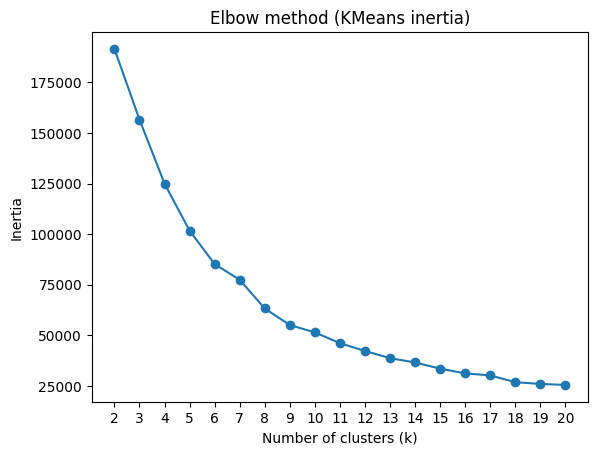

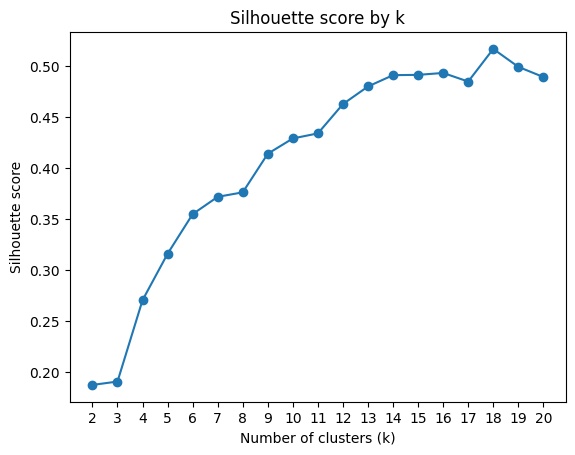

Selected k (max silhouette): 18


,total_deposit,total_ggr,net_deposit,active_days,recency_days,casino_share,tenure_days,any_ftd
segment,,,,,,,,
0,0.93,1099.28,0.67,3.0,498.0,1.00,10.0,1.0
1,1.50,0.00,0.70,2.0,121.0,0.00,3.0,1.0
2,9801.17,1276892.46,9066.77,206.0,29.5,0.50,422.0,0.5
3,0.00,0.00,0.00,0.0,114.0,0.00,0.0,0.0
4,608.83,503635.77,390.35,239.0,4.0,1.00,661.0,1.0
5,5.11,3324.55,2.41,16.0,148.0,1.00,311.0,1.0
6,0.00,199.80,0.00,1.0,628.0,1.00,0.0,0.0
7,2143.43,1706752.01,1296.05,433.0,1.0,1.00,786.5,0.0
8,0.00,398.90,0.00,8.0,183.0,1.00,509.0,0.0


In [15]:
seg = player.copy()

FEATURES = ["total_deposit","total_ggr","net_deposit","active_days","recency_days","casino_share","tenure_days","any_ftd"]
X = seg[FEATURES].replace([np.inf, -np.inf], np.nan).fillna(0)

# Scale features (important for KMeans)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ---- K selection: Elbow + Silhouette ----
k_min, k_max = 2, 20  # 
ks = list(range(k_min, k_max + 1))

inertias = []
silhouettes = []

for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))

# Elbow plot (Inertia)
plt.figure()
plt.plot(ks, inertias, marker="o")
plt.title("Elbow method (KMeans inertia)")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.xticks(ks)
plt.show()

# Silhouette plot
plt.figure()
plt.plot(ks, silhouettes, marker="o")
plt.title("Silhouette score by k")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette score")
plt.xticks(ks)
plt.show()

# ---- Auto-select k (max silhouette) ----
k_best = ks[int(np.argmax(silhouettes))]
print("Selected k (max silhouette):", k_best)

# Fit final model
kmeans = KMeans(n_clusters=k_best, random_state=42, n_init="auto")
seg["segment"] = kmeans.fit_predict(X_scaled)

# Segment medians for interpretation
seg_summary = seg.groupby("segment")[FEATURES].median().round(2)
seg_summary


In [16]:
segment_summary = (seg.groupby("segment", as_index=False)
                   .agg(
                       players=("user_id","count"),
                       total_deposit=("total_deposit","sum"),
                       total_ggr=("total_ggr","sum"),
                       median_deposit=("total_deposit","median"),
                       median_ggr=("total_ggr","median"),
                       median_active_days=("active_days","median"),
                       median_recency=("recency_days","median"),
                       casino_share=("casino_share","median"),
                       ftd_rate=("any_ftd","mean"),
                   )
                  .sort_values("total_ggr", ascending=False))

segment_summary


,segment,players,total_deposit,total_ggr,median_deposit,median_ggr,median_active_days,median_recency,casino_share,ftd_rate
4,4,95,66031.080121,52470884.39,608.826747,503635.770,239.0,4.0,0.998067,0.557895
10,10,520,85963.624893,45623622.29,132.901287,68388.110,144.5,13.0,0.994428,0.692308
7,7,14,33511.262621,23122389.00,2143.427582,1706752.010,433.0,1.0,0.999810,0.285714
15,15,127,38184.542322,18453253.37,239.043531,137434.000,351.0,2.0,0.984039,0.417323
5,5,1345,26254.849165,14828348.92,5.111927,3324.550,16.0,148.0,1.000000,1.000000
16,16,987,16399.615644,10043928.47,5.052369,3469.500,27.0,52.0,1.000000,1.000000
9,9,2492,15696.509965,9437312.19,1.083715,1200.000,3.0,80.0,1.000000,1.000000
14,14,2,8547.959223,8497129.23,4273.979611,4248564.615,294.0,1.5,0.998980,0.500000
0,0,1836,11898.993119,6881645.17,0.933458,1099.275,3.0,498.0,1.000000,1.000000
8,8,1159,12140.087466,3775400.08,0.000000,398.900,8.0,183.0,1.000000,0.000000


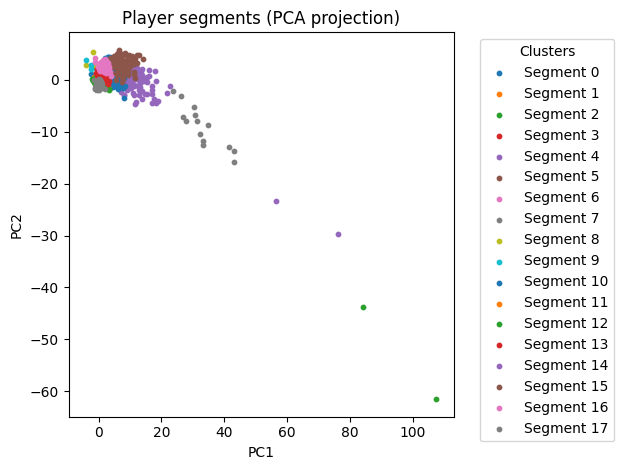

In [17]:
pca = PCA(n_components=2, random_state=42)
Z = pca.fit_transform(X_scaled)

plt.figure()

segments = np.sort(seg["segment"].unique())
for s in segments:
    idx = seg["segment"].values == s
    plt.scatter(Z[idx, 0], Z[idx, 1], label=f"Segment {s}", s=10)

plt.title("Player segments (PCA projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Clusters", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

### Answer 3 — Player Segmentation

#### GGR proxy and segmentation QA check

#### Compute `total_ggr` for segmentation:
Segmentation uses **value** features. In iGaming, **deposits alone do not represent operator value**, so I compute a **GGR proxy** from betting and winnings:
$$
\text{GGR\_proxy}_{u,t}
=
(\text{casino\_bet}_{u,t}-\text{casino\_win}_{u,t})
+
(\text{sports\_bet}_{u,t}-\text{sports\_win}_{u,t})
$$
Then I aggregate to the player level:

$$
\text{total\_ggr}_{u}
=
\sum_{t}\text{GGR\_proxy}_{u,t}
$$
$$
\text{total\_deposit}_{u}
=
\sum_{t}\text{deposit}_{u,t},
\qquad
\text{total\_withdraw}_{u}
=
\sum_{t}\text{withdraw}_{u,t}
$$
$$
\text{net\_deposit}_{u}
=
\text{total\_deposit}_{u}
-
\text{total\_withdraw}_{u}
$$

This ensures clustering reflects three complementary dimensions:

- **Cash contribution:** deposits / net deposits  
- **Revenue contribution:** GGR proxy (`total_ggr`)  
- **Engagement / lifecycle:** active days, recency, tenure, FTD flag  

### QA check context
Because some segments show **deposit ≈ 0 but positive GGR proxy** (e.g., Segment 6: $\text{total\_deposit}=0$, $\text{total\_ggr}\approx 199.8$), I ran a quick QA check **before** interpreting clusters.

This pattern can be either:
- **Valid behavior:** bonus/free-play mechanisms, credit betting, promotional wagering  
- **Data issues:** wrong sign convention, missing deposit tracking, aggregation/join mismatches  

### What the QA check verifies
Before interpreting segments, the QA check validates:

1) **Sign convention is correct**  
If the formula is flipped (wins − bets), “high-value” players can look negative.

2) **Aggregation consistency**  
Deposits and bets/wins are aggregated at the same player and time grain.  
Missing joins can create “bets/wins without deposits” artifacts.

3) **Whether deposit = 0 & GGR > 0 cases are real**  
If real → likely bonus/free-play/promo mechanics.  
If not real → tracking or pipeline issue to resolve.

Only after confirming these points do I interpret the segment personas and propose business actions.



In [18]:
# Build player-level totals (including a clean GGR proxy)
# casino_bet_amount, casino_win_amount, sports_bet_amount, sports_win_amount
# deposit_amount, withdraw_amount, user_id

df2 = df.copy()

for c in [
    "casino_bet_amount","casino_win_amount",
    "sports_bet_amount","sports_win_amount",
    "deposit_amount","withdraw_amount"
]:
    if c in df2.columns:
        df2[c] = pd.to_numeric(df2[c], errors="coerce").fillna(0.0)

# GGR proxy: bets - wins (casino + sports)
df2["ggr_proxy_row"] = (
    (df2["casino_bet_amount"] - df2["casino_win_amount"]) +
    (df2["sports_bet_amount"] - df2["sports_win_amount"])
)

player = (
    df2.groupby("user_id", as_index=False)
       .agg(
           total_deposit=("deposit_amount","sum"),
           total_withdraw=("withdraw_amount","sum"),
           total_ggr=("ggr_proxy_row","sum"),
           n_rows=("ggr_proxy_row","size"),
       )
)
player["net_deposit"] = player["total_deposit"] - player["total_withdraw"]

player.head()


,user_id,total_deposit,total_withdraw,total_ggr,n_rows,net_deposit
0,33178,1.030000,2.140000,0.0,23,-1.110000
1,34769,0.000000,0.000000,0.0,3,0.000000
2,74056,0.000000,0.000000,0.0,1,0.000000
3,236255,3.407373,1.460063,4144.8,24,1.947310
4,236537,5.176922,8.845989,-2736.3,22,-3.669067


In [19]:
# QA: check sign conventions (is the “GGR proxy” behaving normally?)

# In many iGaming datasets, GGR (operator revenue) is typically >= 0 over long periods.
# But it can be negative for some users (big winners), so don't force positivity.

print("Share of players with total_ggr < 0:", (player["total_ggr"] < 0).mean())
print("Share of players with total_ggr = 0:", (player["total_ggr"] == 0).mean())

# Look at extremes
display(player.sort_values("total_ggr").head(10))
display(player.sort_values("total_ggr", ascending=False).head(10))


Share of players with total_ggr < 0: 0.10061463959769044
Share of players with total_ggr = 0: 0.48329297820823247


,user_id,total_deposit,total_withdraw,total_ggr,n_rows,net_deposit
3331,539852,40.047754,0.000000,-733172.90,59,40.047754
3689,566808,530.859509,1045.893990,-598401.55,20,-515.034481
2779,517603,114.874492,506.585219,-395381.22,173,-391.710727
2659,516030,814.116178,1187.488741,-310411.87,64,-373.372563
20395,1043669,38.561366,278.744425,-270002.05,42,-240.183059
3266,533634,877.396289,1164.833882,-257436.83,40,-287.437593
3986,588296,108.677727,367.508820,-256129.11,65,-258.831093
23727,1126174,10.088712,193.170843,-208036.70,7,-183.082131
1861,493128,530.494635,430.791140,-204150.05,51,99.703495
11179,819020,29.406782,218.428402,-192395.00,46,-189.021620


,user_id,total_deposit,total_withdraw,total_ggr,n_rows,net_deposit
1713,487451,4805.914274,1093.039099,4833889.23,451,3712.875175
6508,721881,3742.044949,892.344660,3663240.00,142,2849.700289
3993,589411,2181.253961,237.028963,2832143.06,450,1944.224998
1975,494860,2105.601203,51.985046,2614776.43,416,2053.616157
6316,710103,1932.397811,140.839871,2074119.30,158,1791.557940
327,320979,4849.161111,3637.472343,2030908.51,287,1211.688768
1925,493797,1814.202760,219.822137,1929317.05,590,1594.380623
1819,491056,2517.952415,925.429565,1729752.18,325,1592.522850
316,320100,2779.998692,1549.210622,1710780.27,244,1230.788070
6338,711344,2007.532386,646.227611,1702723.75,400,1361.304775


In [20]:
# QA: flag “deposit ~ 0 but GGR > 0” players (the weird cluster pattern)
eps = 1e-9

weird = player[(player["total_deposit"] <= eps) & (player["total_ggr"] > 0)]
print("Players with deposit ~0 but GGR > 0:", len(weird), f"({len(weird)/len(player):.2%})")

display(weird.sort_values("total_ggr", ascending=False).head(20))


Players with deposit ~0 but GGR > 0: 2203 (8.21%)


,user_id,total_deposit,total_withdraw,total_ggr,n_rows,net_deposit
3645,562398,0.0,0.000000,44816.00,2,0.000000
9896,779402,0.0,0.000000,10166.81,138,0.000000
2255,507224,0.0,0.000000,10000.00,1,0.000000
4169,609541,0.0,0.000000,9999.65,2,0.000000
446,420445,0.0,0.998504,9489.03,308,-0.998504
685,464517,0.0,0.000000,9120.20,144,0.000000
1025,472078,0.0,0.000000,8155.81,17,0.000000
6592,726553,0.0,0.000000,6778.24,54,0.000000
4733,654181,0.0,0.000000,6255.89,136,0.000000
3126,526807,0.0,0.000000,6199.20,1,0.000000


In [21]:
# Drill into a few “weird” users to see if it’s legit (bonus/free-play vs data bug)

sample_ids = weird["user_id"].head(5).tolist()

cols = [
    "date","brand","user_id",
    "deposit_amount","withdraw_amount",
    "casino_bet_amount","casino_win_amount",
    "sports_bet_amount","sports_win_amount",
    "ggr_proxy_row"
]
cols = [c for c in cols if c in df2.columns]

display(df2[df2["user_id"].isin(sample_ids)][cols].sort_values(["user_id","date"]).head(200))


,date,brand,user_id,deposit_amount,withdraw_amount,casino_bet_amount,casino_win_amount,sports_bet_amount,sports_win_amount,ggr_proxy_row
80515,2022-10-09,L,243016,0.0,0.0,46.0,48.0,0.0,0.0,-2.0
245595,2023-09-08,L,243016,0.0,0.0,5.0,1.5,0.0,0.0,3.5
39481,2022-07-14,L,264084,0.0,0.0,62.5,53.6,0.0,0.0,8.9
2000,2022-01-13,L,264742,0.0,0.0,85.0,85.5,0.0,0.0,-0.5
143469,2023-02-14,L,264742,0.0,0.0,1.0,0.0,0.0,0.0,1.0
38655,2022-07-12,L,267890,0.0,0.0,47.0,45.8,0.0,0.0,1.2
114810,2022-12-08,L,267890,0.0,0.0,12.0,11.8,0.0,0.0,0.2
31700,2022-06-16,L,281441,0.0,0.0,582.0,497.6,0.0,0.0,84.4
105504,2022-11-21,L,281441,0.0,0.0,102.0,101.1,0.0,0.0,0.9


If bets exist without deposits -> likely bonus/credit/free-play or deposits recorded elsewhere.

If wins or bets are missing/zero inconsistently -> likely tracking/ETL issue.

#### Player Segmentation

Clustered players using **value + engagement + lifecycle + mix** features:

- **Value:** `total_deposit`, `net_deposit`, `total_ggr` (revenue proxy)  
- **Engagement:** `active_days`, `recency_days` *(lower = more recent)*  
- **Mix:** `casino_share` (casino vs sports)  
- **Lifecycle:** `tenure_days`, `any_ftd` (ever made first deposit)

#### The segmentation story in 3 tiers

#### Tier 1 — VIPs / whales (tiny % of users, huge % of value)
**Key characteristic:** extremely high `total_ggr` and `total_deposit`, **very frequent activity**, **very recent**, mostly **casino-heavy**.

- **Whales (Segments 7, 14):**  
  Small groups (14 + 2 players) with *massive* per-player impact (recency ≈ 1 day).  
  **Business meaning:** a few players can swing the whole month.

- **VIP loyalists / high-value regulars (Segments 4, 15):**  
  Still small (95 + 127 players), but more “stable” than whales: high activity (200–350+ active days) and strong GGR proxy.  
  **Business meaning:** this is the core revenue engine; protect and retain.

**Actions:** VIP retention + dedicated support + responsible gaming controls.  
**Reporting tip:** track KPIs “with and without whales” to avoid distorted averages.

#### Tier 2 — Scaled base (many users, moderate value; lifecycle is the lever)
**Key characteristic:** meaningful volume due to **size**, not because each player is high value. Often converted (FTD), but engagement varies.

- **Mid-high engaged base (Segment 10):**  
  Large (520 players), solid activity, fairly recent, high casino share.  
  **Business meaning:** reliable contributor; retention and lifecycle management pays off.

- **Converted casuals / returning casuals (Segments 5, 16):**  
  Very large (1,345 + 987). Deposits are low (€~5 median), recency is worse (many are cold).  
  **Business meaning:** growth lever = reactivation and earlier retention.

- **Low deposit but “high-ish” GGR proxy (Segment 9):**  
  Large (2,492) with an unusual deposit↔GGR relationship.  
  **Business meaning:** could be bonus-driven turnover or a measurement artifact → treat as QA + promo-policy review.

**Actions:** lifecycle messaging, win-back tests, onboarding-to-week-4 retention focus, promo effectiveness checks.

#### Tier 3 — Low/zero value (largest population; acquisition + activation problem)
**Key characteristic:** little/no deposit, little/no GGR, low activity or one-touch behavior.

- **Never-active / never-converted bulk (Segment 3) + long-lapsed (17):**  
  Very large (6,012 + 1,701) with near-zero value signals.  
  **Business meaning:** acquisition quality and activation funnel are the issue.

- **One-touch / active-but-no-deposit pockets (Segments 11, 8):**  
  Some engagement but no conversion.  
  **Business meaning:** friction in deposit path, KYC/payment issues, or tracking gaps.

- **Sports-heavy converters with low casino GGR (Segments 1/12/13):**  
  Casino share ≈ 0, low/zero median GGR in current proxy.  
  **Business meaning:** treat sports as its own funnel and confirm the sports GGR proxy pipeline.

**Actions:** improve activation funnel (KYC/payment UX), tighten acquisition targeting, add deposit conversion nudges, fix tracking.

#### What’s *different* between high vs low tiers (clear characteristics)
- **High tiers:** low recency (recent), high active days, long tenure, high casino share, high deposits + high GGR proxy  
- **Low tiers:** high recency (stale), low/zero active days, short/zero tenure signals, low/zero deposits and GGR, many never converted (FTD=0)

#### Differences *within* tiers (so it’s not just “high vs low”)

#### Within the **high-value** tier (not all “VIPs” are the same)
- **Whales / Super-whales (Segments 7, 14)**
  - **Signature:** extremely high *per-player* `total_deposit` + `total_ggr`, **very low** `recency_days` (often ~1–2), very high `active_days`.
  - **What’s different:** value is **highly concentrated**; losing 1–2 players can move the global total.
  - **Operational focus:** “white-glove” retention + risk controls + scenario reporting (“with/without whales”).

- **VIP loyalists / High-value regulars (Segments 4, 15)**
  - **Signature:** high `total_ggr` and strong deposits, **very consistent engagement** (high `active_days`), long `tenure_days`.
  - **What’s different:** more **stable** than whales; better candidates for long-term loyalty programs.
  - **Operational focus:** loyalty tiers, personalization, retention journeys.

- **Mid-high engaged base (Segment 10)**
  - **Signature:** lower per-player value than VIPs, but **large segment size** with decent engagement.
  - **What’s different:** this is the “scalable engine” — total impact comes from **volume**, not individual extremes.
  - **Operational focus:** lifecycle optimization + early churn prevention.

#### Within the **low-value** tier (different failure modes)
- **Never-active / never-converted bulk (Segment 3, plus long-lapsed 17)**
  - **Signature:** `deposit≈0`, `ggr≈0`, `active_days≈0`, `any_ftd=0`.
  - **Meaning:** acquisition quality / onboarding conversion problem.
  - **Action:** improve activation funnel (KYC/payment UX), acquisition filtering, onboarding experiments.

- **One-touch accounts (Segment 11)**
  - **Signature:** `active_days≈1`, still `deposit=0`, `FTD=0`.
  - **Meaning:** curiosity / first session happened but conversion failed.
  - **Action:** “first session → deposit” nudges, reduce friction, targeted reminders immediately after first touch.

- **Active but no deposits (Segment 8)**
  - **Signature:** `active_days>0` + `deposit=0` but `total_ggr > 0` in the proxy.
  - **Meaning:** could be **bonus/free-play mechanics** OR **tracking mismatch** (deposit not captured).
  - **Action:** funnel diagnostics + tracking QA (confirm deposit capture), then decide promo strategy.

- **Sports-heavy converters (Segments 1 / 12 / 13)**
  - **Signature:** `casino_share≈0`, low/zero `median_ggr` under current proxy, but `any_ftd=1`.
  - **Meaning:** different product behavior (sports-only) and/or proxy not representing sports well.
  - **Action:** treat as a separate sports funnel; verify sports GGR proxy and build sports-specific lifecycle actions.

#### Takeaway
1) **Value is extremely concentrated** in a small VIP/whale tier → month-to-month totals can swing based on a handful of players.  
2) **Biggest scalable lever** is moving large low-value tiers through **activation → FTD → early retention**.  
3) Use segmentation to run **tier-specific actions** (VIP protection, lifecycle reactivation, funnel fixes) rather than one-size-fits-all campaigns.


---

### Task 4 — Forecasting monthly deposits

Goal: forecast monthly deposits (globally or per brand).

Approach:
- Aggregate deposits to monthly series
- Train/test split on time
- Baseline: seasonal naive or last-month
- Model: SARIMAX (seasonality = 12 months), XGBoost, LSTM
- Provide uncertainty with prediction intervals

Limitations:
- Forecast quality depends on consistent seasonality and stable business conditions
- Promotions, payment changes, affiliate campaigns can cause structural breaks


In [22]:
# extract global monthly deposits
monthly = (df.set_index("date")
           .resample("MS")["deposit_amount"]
           .sum()
           .rename("monthly_deposits")
           .to_frame())

print(monthly.head())
print(monthly.tail())


            monthly_deposits
date                        
2022-01-01       7418.291477
2022-02-01       4797.136796
2022-03-01       6213.300342
2022-04-01       6913.843131
2022-05-01       6720.929324
            monthly_deposits
date                        
2023-11-01      16436.331913
2023-12-01      18491.185833
2024-01-01      19275.619529
2024-02-01      19167.158345
2024-03-01      19005.206336


#### EDA
Seasonal check

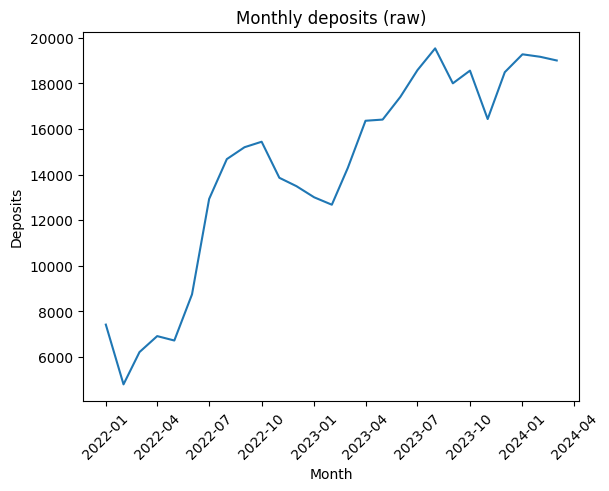

Number of months: 27


In [23]:
# y_all is monthly series
y = monthly["monthly_deposits"].astype(float).copy().sort_index()

# force monthly start frequency and fill missing months (important for seasonal checks)
full_idx = pd.date_range(y.index.min(), y.index.max(), freq="MS")
y = y.reindex(full_idx).fillna(0.0)  # or interpolate; for deposits, 0 is often OK if truly no activity

plt.figure()
plt.plot(y.index, y.values)
plt.title("Monthly deposits (raw)")
plt.xlabel("Month")
plt.ylabel("Deposits")
plt.xticks(rotation=45)
plt.show()

print("Number of months:", len(y))


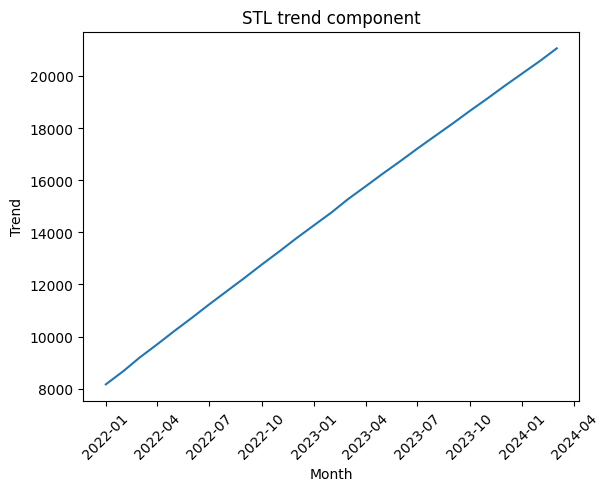

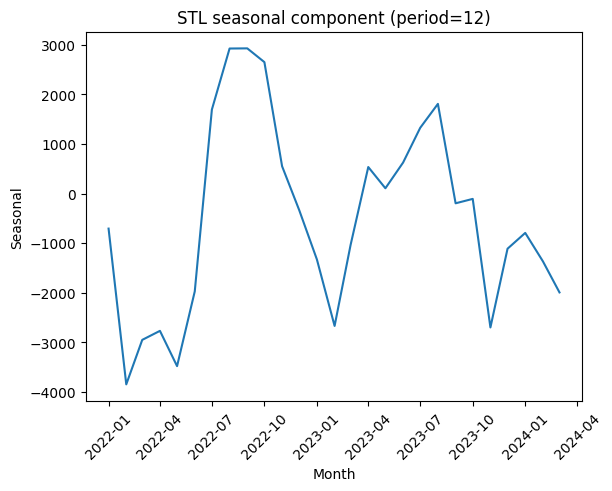

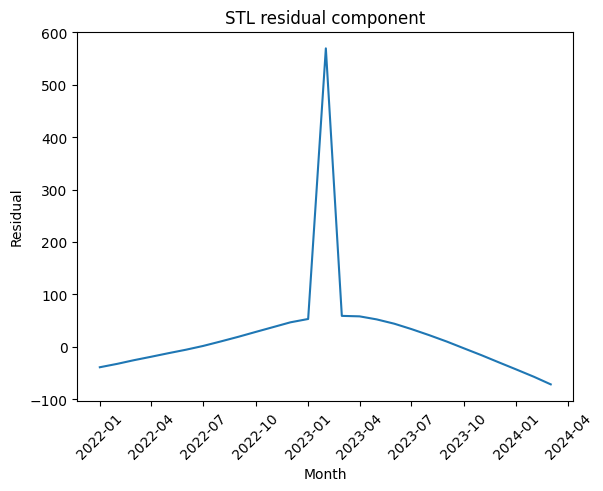

In [24]:
from statsmodels.tsa.seasonal import STL

# STL needs a period; for monthly data, try 12
stl = STL(y, period=12, robust=True)
res = stl.fit()

plt.figure()
plt.plot(res.trend.index, res.trend.values)
plt.title("STL trend component")
plt.xlabel("Month")
plt.ylabel("Trend")
plt.xticks(rotation=45)
plt.show()

plt.figure()
plt.plot(res.seasonal.index, res.seasonal.values)
plt.title("STL seasonal component (period=12)")
plt.xlabel("Month")
plt.ylabel("Seasonal")
plt.xticks(rotation=45)
plt.show()

plt.figure()
plt.plot(res.resid.index, res.resid.values)
plt.title("STL residual component")
plt.xlabel("Month")
plt.ylabel("Residual")
plt.xticks(rotation=45)
plt.show()


In [25]:
# Residual spike investigation

spike_month = res.resid.abs().idxmax()
print("Spike month:", spike_month)
print("Actual deposits that month:", y.loc[spike_month])
print("Trend:", res.trend.loc[spike_month], "Seasonal:", res.seasonal.loc[spike_month], "Residual:", res.resid.loc[spike_month])

spike_month = res.resid.abs().idxmax()

month_start = pd.Timestamp(spike_month).to_period("M").to_timestamp(how="start")
month_end   = month_start + pd.offsets.MonthBegin(1)

tmp = df[(df["date"] >= month_start) & (df["date"] < month_end)].copy()


month_total = tmp["deposit_amount"].sum()

brand_sum = tmp.groupby("brand")["deposit_amount"].sum().sort_values(ascending=False)
user_sum  = tmp.groupby("user_id")["deposit_amount"].sum().sort_values(ascending=False)

top10 = user_sum.head(10).sum()
top1  = user_sum.head(1).sum()

print("Month:", month_start.date(), "Total deposits:", month_total)
print("\nBrand contribution:")
print((brand_sum / month_total).round(3))   # shares
print("\nTop users contribution:")
print("Top1 share :", float(top1 / month_total) if month_total else np.nan)
print("Top10 share:", float(top10 / month_total) if month_total else np.nan)
print("\nTop 10 users (absolute):")
print(user_sum.head(10))


Spike month: 2023-02-01 00:00:00
Actual deposits that month: 12677.820349
Trend: 14777.17560560903 Seasonal: -2668.98146240855 Residual: 569.6262057995191
Month: 2023-02-01 Total deposits: 12677.820349

Brand contribution:
brand
L    0.841
S    0.159
J    0.000
Name: deposit_amount, dtype: float64

Top users contribution:
Top1 share : 0.042306038280650195
Top10 share: 0.17625844289363657

Top 10 users (absolute):
user_id
361918    536.348353
508576    269.524309
320100    240.207490
464683    199.337521
477009    198.757176
699530    174.242438
516281    159.725690
483831    157.194204
857072    153.766093
780113    145.469600
Name: deposit_amount, dtype: float64


### Forecasting setup — EDA summary and the evaluation design

#### 1) the monthly deposits series (EDA + STL)

After aggregating deposits to monthly totals, the series is **short** (≈27 months) and dominated by three effects:

**(a) Clear trend (non-stationary level)**  
Deposits rise materially over time, so the raw level is not stationary. This affects both seasonality detection and model stability.

**(b) Shocks / volatility (one-off deviations)**  
STL decomposition shows at least one **residual spike month** (i.e., a month not explained by trend + seasonality).  
When I drilled down into the largest spike (Feb 2023), I observed:

- **Total deposits:** €12.7k  
- **Brand contribution:** L = 84.1%, S = 15.9%, J ≈ 0  
- **Top user concentration:** Top1 share ≈ 4.2%, Top10 share ≈ 17.6% → **not a single “whale” month**, more broad-based

This matters because spikes can be caused by campaigns, payment/provider changes, VIP behaviour shifts, or reporting artifacts — and they can destabilize classical time-series models.

**(c) Seasonality exists but is not “clean”**  
STL suggests some seasonal structure, but with limited history it’s risky to assume a strong, stable yearly pattern and hard-code it. In short: seasonality is plausible, but not “proven” with high confidence.

**Implication (model choices):** With a short, trending, shock-prone series and weak/uncertain seasonality, I treat:
- **SARIMAX** as an interpretable benchmark,
- **XGBoost** (lags/rolling features) as a robust alternative,
- **LSTM** only as a secondary benchmark (small model, strong regularization) because deep learning typically needs more data.

#### 2) Global vs brand-level:

Deposits are highly concentrated in **brand L**, and the spike month confirms that when deposits move, **L explains most of it**.

That supports this operating model:
- Forecast **global deposits** for planning and budgeting (most stable signal),
- optionally allocate to brands (**top-down**) for actionability and coherent reporting.

#### 3) Evaluation metrics

- **MAE (Mean Absolute Error):** average monthly miss in currency units (“off by about €X per month”).
- **RMSE:** like MAE but penalizes large misses more (useful when big misses are costly).
- **WAPE (Weighted Absolute Percentage Error):** a volume-weighted error ratio (e.g., WAPE = 0.18 means ~18% miss of total volume in the validation period).
- **MASE (Mean Absolute Scaled Error):** a “sanity check” vs a naive baseline:
  - MASE < 1 → better than naive  
  - MASE > 1 → worse than naive (not worth the complexity)

Note: $R^2$ as a diagnostic only, not a primary model-selection metric for short-horizon forecasting.

On short validation windows (e.g., 6 months), especially with trend and shocks, $R^2$ can:
- swing widely between folds,
- become strongly negative even when errors are business-acceptable,
- punish models that are “close” but miss variance in a small window.

#### 4) Naive baselines

Baselines: idea to see “Is the model adding value or just adding complexity?”

- **Naive baseline:** next month ≈ last month  
  Per fold: $\hat{y}_{t+1:t+h} = y_t$

- **Seasonal naive (monthly):** next month ≈ same month last year  
  Per fold: $\hat{y}_t = y_{t-12}$

Even if I don’t ship a naive model, I keep these baselines because:
- if SARIMAX/XGBoost/LSTM can’t beat naive on MAE/WAPE/MASE, the model is not adding predictive value — it’s just complexity.

#### 5) Rolling validation (walk-forward) (which is better than “standard TimeSeriesSplit”)

With only ~27 monthly points, standard time-series CV (fixed `n_splits`) creates early folds with very small training windows. That makes results unstable — especially for SARIMAX (parameter estimates become noisy) and for any model sensitive to trend.

**What “rolling validation” means**  
For each fold $i$:
1) Train on all data up to time $T_i$ (expanding window)
2) Forecast the next $h$ months $$\left(T_i+1,\dots,T_i+h\right)$$
3) Slide forward and repeat

This matches how forecasting is used in production (“train on history → forecast forward”), and it lets me enforce:
- a minimum training history (e.g., 12 months), and
- a fixed horizon (e.g., 6 months) consistent with planning needs.

**Key point:** rolling validation doesn’t “improve” the model — it makes evaluation **more realistic and more stable**, which is crucial for tuning (e.g., Optuna) and stakeholder trust.

#### 6) Transformations to reduce overfitting and stabilize learning (why dlog1p helps)

With trend + shocks, working directly on raw levels can overemphasize spikes.

Common stabilizing transforms:

- **Log transform:**  
  $$
  y'_t = \log(1 + y_t)
  $$  
  Reduces the impact of extreme values and improves robustness.

- **Differenced log (growth/change modeling):**  
  $$
  d_t = \log(1+y_t) - \log(1+y_{t-1})
  $$  
  Shifts the task from “predict level” to “predict change,” which is often easier with short, trending series.

**In practice:**
- **XGBoost:** learns **1-step changes** (using lag + rolling + calendar features), then forecasts **recursively** forward.
- **SARIMAX:** models the series with **trend/differencing** (and optional seasonality) and can output **prediction intervals**.
- **LSTM (small):** learns a **sequence-to-one** mapping from the last $k$ months to next month, e.g.  
 $$ 
 \hat{y}_{t+1} = f\!\left(y_t, y_{t-1}, \dots, y_{t-k+1}\right)
 $$  
 In this setup, I typically train on the transformed target (e.g., $d_t$ from $d\log(1+y)$) to stabilize learning, then:
 1) predict the next change $\hat{d}_{t+1}$,  
 2) reconstruct the level by accumulating changes back into $\log(1+y)$,  
 3) invert with $y=\exp(\cdot)-1$.

  **Why “small” matters here:** with only ~27 monthly points, a large LSTM will overfit. I keep it minimal (few units, dropout, early stopping) and treat it as a secondary benchmark rather than the primary model.

**Important:** transformations are applied **inside each fold** (train only) to avoid leakage.

#### 7) Practical benchmark plan

Given the EDA (trend + shocks + uncertain seasonality), I benchmark in this order:

1) **Naive / seasonal naive** — sanity check  
2) **SARIMAX** — interpretable statistical baseline + intervals  
3) **XGBoost** with lag/rolling/calendar features — robust on short data, good for explainability  
4) **LSTM (small)** — benchmark; avoid large architectures with limited monthly history (using Kaggle + T4 GPU)

#### 8) Assumptions, limitations, and uncertainty (how I communicate it)

**Assumptions**
- Forecast target is monthly total deposits (global; optional brand allocation).
- Forecast uses mostly historical deposit behaviour (limited exogenous drivers).

**Limitations**
- Short history (≈27 months) limits learning of stable yearly seasonality.
- Shocks/spikes can dominate fitting and reduce reliability.
- Without exogenous inputs (campaign calendar, bonuses, PSP incidents), the model can’t “predict” shocks — only react after they occur.

**Uncertainty**
I communicate forecast ranges (base/downside/upside), using:
- fold-to-fold error variability (rolling backtest distribution), and
- prediction intervals when available (SARIMAX), or bootstrap-style intervals for ML if needed.

In [26]:
# monthly must look like:
# index: monthly datetime (MS)
# column: monthly_deposits

monthly = monthly.copy().sort_index()
y_all = monthly["monthly_deposits"].astype(float)

test_months = 6
train_y = y_all.iloc[:-test_months]
test_y  = y_all.iloc[-test_months:]

print("Train months:", train_y.index.min(), "->", train_y.index.max(), "n=", len(train_y))
print("Test months :", test_y.index.min(),  "->", test_y.index.max(),  "n=", len(test_y))


Train months: 2022-01-01 00:00:00 -> 2023-09-01 00:00:00 n= 21
Test months : 2023-10-01 00:00:00 -> 2024-03-01 00:00:00 n= 6


- **MAE (€):** average absolute miss in deposits (e.g., “off by ~€X/month”).
- **RMSE (€):** like MAE but penalizes large misses more (useful when big errors are costly).
- **WAPE:** volume-weighted error, $\text{WAPE}=\frac{\sum_t |y_t-\hat{y}_t|}{\sum_t |y_t|}$.  
  Example: WAPE = 0.18 ≈ “18% of total volume missed” over the backtest period.
- **MASE:** error scaled vs a naive baseline; **MASE < 1** beats naive, **MASE > 1** does not.

In [27]:
def wape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.sum(np.abs(y_true))
    denom = denom if denom != 0 else 1.0
    return np.sum(np.abs(y_true - y_pred)) / denom

def mase(y_true, y_pred, y_train):
    """
    Scale = average absolute 1-step change on training (naive 1-step forecast error).
    Interpretable: MASE < 1 means better than naive.
    """
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    y_train = np.asarray(y_train, dtype=float)

    if len(y_train) < 2:
        return np.nan

    scale = np.mean(np.abs(np.diff(y_train)))
    scale = scale if scale != 0 else 1.0
    return np.mean(np.abs(y_true - y_pred)) / scale

def fold_metrics(y_true, y_pred, y_train):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)

    mae = float(np.mean(np.abs(y_true - y_pred)))
    rmse = float(np.sqrt(np.mean((y_true - y_pred) ** 2)))

    return {
        "MAE": mae,
        "RMSE": rmse,
        "WAPE": float(wape(y_true, y_pred)),
        "MASE": float(mase(y_true, y_pred, y_train)),
    }


In [28]:
# Seasonal naive (monthly): next month ≈ same month last year  

def seasonal_naive_forecast(
    y_full: pd.Series,
    va_index: pd.DatetimeIndex,
    seasonal_lag: int = 12,
    fallback: float | None = None,
) -> pd.Series:
    """
    True seasonal naive: y_hat(t) = y(t - seasonal_lag).
    Falls back to `fallback` (usually last train value) when missing.
    """
    y_full = y_full.astype(float).copy()
    y_full.index = pd.to_datetime(y_full.index)

    pred = y_full.shift(seasonal_lag).reindex(va_index)
    if fallback is None:
        fallback = float(y_full.dropna().iloc[-1])
    pred = pred.fillna(float(fallback)).clip(lower=0)
    pred.index = va_index
    return pred

## Helper functions

These helper functions standardize the time index, define the forecast horizon, and implement the *dlog1p* transformation workflow used later by the XGBoost recursive forecaster.

#### 1) `_as_monthly_start(y)`
**Goal:** enforce a clean **monthly start** time index.

- Converts the index to `datetime`.
- Tries `asfreq("MS")` to align observations to **Month Start** frequency (`MS`).
- If `asfreq` fails (e.g., irregular index), it leaves the series as-is.

**Why it matters:**
- Many operations in the pipeline assume monthly spacing (lags, rolling windows, SARIMAX seasonality).
- To be standardized, it can avoid misalignment bugs (wrong lags, wrong forecast dates).

**Used later in:**
- any supervised feature construction (lags/rolling features)
- XGBoost recursive forecast
- SARIMAX baseline preparation

#### 2) `_future_index_from_train(y_train, horizon, future_index=None)`
**Goal:** build the **future timestamps** for prediction.

Two modes:
- If `future_index` is passed (e.g., `test_y.index`), it uses that exactly.
- Otherwise, it creates a monthly-start index beginning at the month after the last training date:
  $$ 
  \{\max(t_{\text{train}})+1M, \dots, \max(t_{\text{train}})+hM\} 
  $$

**Why it matters:**
- Prevents “off-by-one month” errors.
- Ensures predicted values can be safely aligned/reindexed to a known test horizon.

**Used later in:**
- `xgb_recursive_forecast_dlog1p(...)`
- any forecasting function that returns a `pd.Series` of predictions

#### 3) `_dlog1p_components(y_train)`
**Goal:** compute the *dlog1p* transformed series and the scaling stats.

Steps:
1) Convert series to monthly start index.
2) Transform level with log1p: $ y'_t = \log(1 + y_t) $
3) Compute the 1-step log difference (growth/change): $ d_t = y'_t - y'_{t-1} $
4) Compute mean and centered version: $ \mu = \mathbb{E}[d_t], \quad d^{(c)}_t = d_t - \mu $
5) Compute scale: $ \sigma = \text{std}(d^{(c)}_t) $ (and guard against $\sigma=0$ by setting it to 1)

Returns:
- monthly series `y`
- log-level array `y_log`
- differenced series `dlog`
- `mu`, `sd`
- centered array `d_center`

**Why it matters:**
- With short + trending series, predicting **levels** directly is hard.
- Predicting **changes** (growth) is often easier and more stable.
- Centering/scaling makes the regression target easier for XGBoost to learn.
- The mean $\mu$ is also used as a “drift” estimate (long-run trend) in the recursive forecast.

**Used later in:**
- 1-step supervised dataset generation (lags on dlog)
- clipping bounds (quantiles on centered dlog)
- reconstruction of future levels after predicting changes

#### 4) `_reconstruct_from_dlog1p(ylog_last, dlog_preds)`
**Goal:** turn predicted future *dlog1p* changes back into **deposit levels**.

Given:
- last observed log-level $y'_{T}$
- predicted changes $\hat{d}_{T+1}, \dots, \hat{d}_{T+h}$

Reconstruct future log-levels: $ \hat{y}'_{T+k} = y'_T + \sum_{i=1}^{k} \hat{d}_{T+i} $

Invert log1p: $ \hat{y}_{T+k} = \exp(\hat{y}'_{T+k}) - 1 $

Then clip:
- deposits can’t be negative, so we clip at 0.

**Why it matters:**
- Model predicts **changes**, not levels.
- This function guarantees a consistent, correct inverse transform back to the business unit.

**Used later in:**
- recursive multi-step forecast loop (XGB predicts dlog step-by-step)
- any method that outputs $ \hat{d}_t $ instead of $ \hat{y}_t $


#### Summary

- `_as_monthly_start` and `_future_index_from_train` prevent **index/frequency bugs**
- `_dlog1p_components` creates a **stable learning target** (growth instead of raw levels)
- `_reconstruct_from_dlog1p` ensures predictions return to **real deposit values** reliably

Together, they make the forecasting pipeline:
- time-consistent,
- less sensitive to shocks/outliers,
- and safer for rolling backtests and production scoring.


In [29]:

def _as_monthly_start(y: pd.Series) -> pd.Series:
    y = y.copy()
    y.index = pd.to_datetime(y.index)
    try:
        y = y.asfreq("MS")
    except Exception:
        pass
    return y

def _future_index_from_train(y_train: pd.Series, horizon: int, future_index=None) -> pd.DatetimeIndex:
    y_train = y_train.copy()
    y_train.index = pd.to_datetime(y_train.index)
    if future_index is not None:
        return pd.DatetimeIndex(pd.to_datetime(future_index))
    return pd.date_range(y_train.index.max() + pd.offsets.MonthBegin(1), periods=horizon, freq="MS")

def _dlog1p_components(y_train: pd.Series):
    """
    Returns: y_train_monthly, y_log(np.array), dlog(pd.Series), mu(float), sd(float), d_center(np.array)
    """
    y = y_train.astype(float).copy()
    y = _as_monthly_start(y)

    y_log = np.log1p(y.values)
    dlog = pd.Series(np.diff(y_log), index=y.index[1:]).astype(float)

    mu = float(dlog.mean())
    d_center = (dlog.values - mu)
    sd = float(np.std(d_center))
    if sd == 0.0:
        sd = 1.0

    return y, y_log, dlog, mu, sd, d_center

def _reconstruct_from_dlog1p(ylog_last: float, dlog_preds: np.ndarray) -> np.ndarray:
    ylog_future = ylog_last + np.cumsum(dlog_preds)
    y_future = np.expm1(ylog_future)
    return np.clip(y_future, 0.0, None)


In [30]:
# ---------- SARIMAX on dlog1p ----------
import statsmodels.api as sm

def sarimax_forecast_dlog1p(
    y_train: pd.Series,
    horizon: int,
    order=(1, 0, 1),                 # ARMA on dlog-centered
    seasonal_order=(0, 0, 0, 0),
    future_index=None,
    drift_strength: float = 0.2,     # 0..1
    clip_q=(0.05, 0.95),
    enforce_stationarity=False,
    enforce_invertibility=False,
):
    """
    Fit SARIMAX on centered dlog1p (stationary-ish), forecast dlog, then reconstruct y.
    """
    y_train = y_train.astype(float).copy()
    y_train = _as_monthly_start(y_train)

    future_idx = _future_index_from_train(y_train, horizon, future_index)
    horizon = len(future_idx)

    # build dlog1p
    y_train, y_log, dlog, mu, sd, d_center = _dlog1p_components(y_train)

    # too small => fallback
    if len(dlog) < 6:
        last = float(y_train.iloc[-1])
        return pd.Series([last] * horizon, index=future_idx)

    # centered series (no scaling needed for SARIMAX)
    d_center_s = pd.Series(d_center, index=dlog.index)

    # SARIMAX on d_center
    model = sm.tsa.statespace.SARIMAX(
        d_center_s,
        order=order,
        seasonal_order=seasonal_order,
        trend=None,  # drift is handled by mu separately
        enforce_stationarity=enforce_stationarity,
        enforce_invertibility=enforce_invertibility,
    )
    res = model.fit(disp=False)

    d_center_pred = res.get_forecast(steps=horizon).predicted_mean.values.astype(float)

    # clip predicted centered dlog to training range (quantiles)
    lo, hi = np.quantile(d_center, clip_q[0]), np.quantile(d_center, clip_q[1])
    d_center_pred = np.clip(d_center_pred, lo, hi)

    # add back damped drift
    d_pred = d_center_pred + drift_strength * mu

    # reconstruct to y scale
    y_future = _reconstruct_from_dlog1p(float(y_log[-1]), d_pred)
    return pd.Series(y_future, index=future_idx)

In [31]:
def rolling_splits(n, min_train=12, test_size=6, step=1):
    splits = []
    end = min_train
    while end + test_size <= n:
        tr_idx = np.arange(0, end)
        va_idx = np.arange(end, end + test_size)
        splits.append((tr_idx, va_idx))
        end += step
    return splits

In [32]:

def rolling_cv_sarimax_dlog1p_vs_baselines(
    y: pd.Series,
    # SARIMAX on dlog-centered (stationary-ish)
    order=(1, 0, 1),
    seasonal_order=(0, 0, 0, 0),
    drift_strength: float = 0.3,
    clip_q=(0.05, 0.95),

    # CV
    min_train=12,
    test_size=6,
    step=1,
    seasonal_lag=12,
    debug_print=False,
):
    y = y.astype(float).copy()
    y.index = pd.to_datetime(y.index)
    try:
        y = y.asfreq("MS")
    except Exception:
        pass

    splits = rolling_splits(len(y), min_train=min_train, test_size=test_size, step=step)
    if len(splits) == 0:
        raise ValueError(
            f"No CV folds: n={len(y)}, min_train={min_train}, test_size={test_size}. "
            f"Need min_train + test_size <= n."
        )

    print(f"Rolling CV folds: {len(splits)}  (n={len(y)}, min_train={min_train}, test_size={test_size}, step={step})")

    rows = []
    for i, (tr_idx, va_idx) in enumerate(splits, start=1):
        y_tr = y.iloc[tr_idx]
        y_va = y.iloc[va_idx]

        # Baseline 1: naive
        pred_naive = pd.Series([float(y_tr.iloc[-1])] * len(y_va), index=y_va.index).clip(lower=0)

        # Baseline 2: seasonal naive (true lag-12)
        pred_seas = y.shift(seasonal_lag).iloc[va_idx]
        pred_seas = pred_seas.fillna(float(y_tr.iloc[-1])).clip(lower=0)
        pred_seas.index = y_va.index

        # ---- SARIMAX dlog1p forecaster (KEY REPLACEMENT) ----
        pred_sarimax = sarimax_forecast_dlog1p(
            y_train=y_tr,
            horizon=len(y_va),
            future_index=y_va.index,          # index-safe
            order=order,
            seasonal_order=seasonal_order,
            drift_strength=drift_strength,
            clip_q=clip_q,
        )

        if debug_print:
            print(f"\nFold {i}: train={len(y_tr)} val={len(y_va)}")
            print("Actual  :", y_va.values)
            print("Naive   :", pred_naive.values)
            print("SeasN   :", pred_seas.values)
            print("SARIMAX :", pred_sarimax.values)

        rows.append({"model": "naive", "split": i, **fold_metrics(y_va.values, pred_naive.values, y_tr.values)})
        rows.append({"model": "seasonal_naive", "split": i, **fold_metrics(y_va.values, pred_seas.values, y_tr.values)})
        rows.append({"model": "sarimax_dlog1p", "split": i, **fold_metrics(y_va.values, pred_sarimax.values, y_tr.values)})

    out = pd.DataFrame(rows)
    summary = (out.groupby("model")[["MAE", "RMSE", "WAPE", "MASE"]]
               .mean()
               .sort_values("MAE"))
    return out, summary


In [33]:
# grid search (2 hyperparameters: drift_strength and clip_q) using 
# the rolling CV WAPE as the objective.

drifts = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
clips  = [(0.01,0.99), (0.05,0.95), (0.10,0.90)]

best = None
for ds in drifts:
    for cq in clips:
        cv_table, cv_sum = rolling_cv_sarimax_dlog1p_vs_baselines(
            train_y,
            order=(1,0,1),
            seasonal_order=(0,0,0,0),
            drift_strength=ds,
            clip_q=cq,
            min_train=12,
            test_size=6,
            step=1,
        )
        score = float(cv_sum.loc["sarimax_dlog1p","WAPE"])
        if best is None or score < best[0]:
            best = (score, ds, cq)

print(best)


Rolling CV folds: 4  (n=21, min_train=12, test_size=6, step=1)
Rolling CV folds: 4  (n=21, min_train=12, test_size=6, step=1)
Rolling CV folds: 4  (n=21, min_train=12, test_size=6, step=1)
Rolling CV folds: 4  (n=21, min_train=12, test_size=6, step=1)
Rolling CV folds: 4  (n=21, min_train=12, test_size=6, step=1)
Rolling CV folds: 4  (n=21, min_train=12, test_size=6, step=1)
Rolling CV folds: 4  (n=21, min_train=12, test_size=6, step=1)
Rolling CV folds: 4  (n=21, min_train=12, test_size=6, step=1)
Rolling CV folds: 4  (n=21, min_train=12, test_size=6, step=1)
Rolling CV folds: 4  (n=21, min_train=12, test_size=6, step=1)
Rolling CV folds: 4  (n=21, min_train=12, test_size=6, step=1)
Rolling CV folds: 4  (n=21, min_train=12, test_size=6, step=1)
Rolling CV folds: 4  (n=21, min_train=12, test_size=6, step=1)
Rolling CV folds: 4  (n=21, min_train=12, test_size=6, step=1)
Rolling CV folds: 4  (n=21, min_train=12, test_size=6, step=1)
Rolling CV folds: 4  (n=21, min_train=12, test_size=6, 

In [34]:
best_score, best_sarimax_drift, best_sarimax_clip = best

# these were FIXED in the grid search loop, so set them explicitly
best_sarimax_order    = (1, 0, 1)
best_sarimax_seasonal = (0, 0, 0, 0)

print("best_score:", best_score)
print("best_sarimax_drift:", best_sarimax_drift)
print("best_sarimax_clip:", best_sarimax_clip)
print("best_sarimax_order:", best_sarimax_order)
print("best_sarimax_seasonal:", best_sarimax_seasonal)


best_score: 0.11425333405471098
best_sarimax_drift: 1.0
best_sarimax_clip: (0.01, 0.99)
best_sarimax_order: (1, 0, 1)
best_sarimax_seasonal: (0, 0, 0, 0)


In [35]:
# --- SARIMAX rolling CV (tuned drift/clip) ---
sarimax_cv_table_tuned, sarimax_cv_summary_tuned = rolling_cv_sarimax_dlog1p_vs_baselines(
    y=train_y,
    order=best_sarimax_order,                 # e.g., (1,0,1)
    seasonal_order=best_sarimax_seasonal,     # e.g., (0,0,0,0) or (1,0,1,12)
    drift_strength=best_sarimax_drift,        # float
    clip_q=best_sarimax_clip,                 # tuple like (0.01,0.99)
    min_train=12,
    test_size=6,
    step=1,
)

display(sarimax_cv_summary_tuned)
display(sarimax_cv_table_tuned.sort_values(["model","split"]))


Rolling CV folds: 4  (n=21, min_train=12, test_size=6, step=1)


,MAE,RMSE,WAPE,MASE
model,,,,
sarimax_dlog1p,1842.875398,2018.826642,0.114253,1.383538
naive,3218.212843,3561.785385,0.193642,2.457535
seasonal_naive,7761.414091,7986.922489,0.475628,5.846952


,model,split,MAE,RMSE,WAPE,MASE
0,naive,1,1968.845004,2368.366958,0.131027,1.388294
3,naive,2,3061.213451,3540.001430,0.191853,2.283393
6,naive,3,4421.345387,4732.883046,0.258571,3.501897
9,naive,4,3421.447531,3605.890105,0.193117,2.656555
2,sarimax_dlog1p,1,2010.681561,2086.844554,0.133811,1.417795
5,sarimax_dlog1p,2,2606.220936,2823.615027,0.163337,1.944009
8,sarimax_dlog1p,3,2151.200126,2256.666137,0.125807,1.703844
11,sarimax_dlog1p,4,603.398970,908.180851,0.034058,0.468504
1,seasonal_naive,1,8224.884115,8335.028887,0.547367,5.799624
4,seasonal_naive,2,8236.105886,8342.590170,0.516174,6.143403


In [36]:
# IMPORTANT: forecast with the exact test index (prevents index-mismatch flatlines)
sarimax_pred_test = sarimax_forecast_dlog1p(
    y_train=train_y,
    horizon=len(test_y),
    future_index=test_y.index,
    order=(1, 0, 1),
    seasonal_order=(0, 0, 0, 0),
    drift_strength=1.0,
    clip_q=(0.01, 0.99),
)

# metrics
sarimax_test_metrics = fold_metrics(test_y.values, sarimax_pred_test.values, train_y.values)
sarimax_test_metrics


{'MAE': 918.7535747020016,
 'RMSE': 1054.053964873009,
 'WAPE': 0.04969100150226942,
 'MASE': 0.7407561799119068}

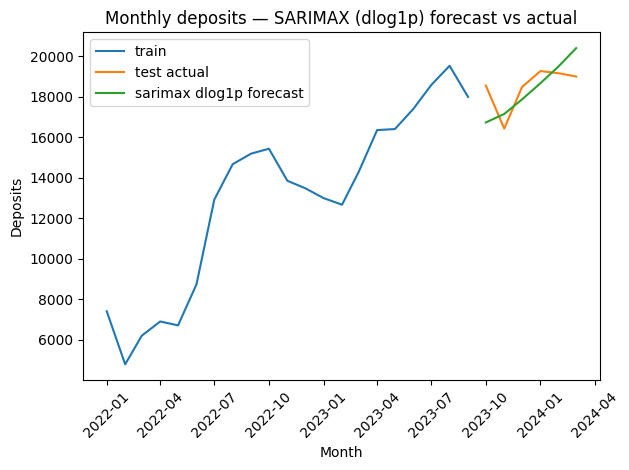

In [37]:
plt.figure()
plt.plot(train_y.index, train_y.values, label="train")
plt.plot(test_y.index, test_y.values, label="test actual")
plt.plot(test_y.index, sarimax_pred_test.values, label="sarimax dlog1p forecast")
plt.title("Monthly deposits — SARIMAX (dlog1p) forecast vs actual")
plt.xlabel("Month")
plt.ylabel("Deposits")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


### Rolling CV & holdout results — SARIMAX ($\Delta \log(1+y)$)

#### Holdout (last 6 months: 2023-10 → 2024-03)

On the final holdout window, SARIMAX($\Delta \log(1+y)$) performs **strongly**:

- **MAE** $\approx €918.8$
- **RMSE** $\approx €1054.1$
- **WAPE** $\approx 0.0497$ (≈ **5%** of total volume)
- **MASE** $\approx 0.741$ $\Rightarrow$ **beats naive** on this period ($<1$)

**Interpretation:**
- The forecast follows the **level + trend** for budgeting.
- Because it’s modeling smoothed log-changes, it tends to be **less reactive** to short-lived dips/rebounds (good for stability, but it can under-capture sudden shocks).

#### Rolling validation (4 folds, each forecasting next 6 months)

Overall (average across folds):

- **SARIMAX:** WAPE $\approx 0.1143$, MASE $\approx 1.3835$
- **Naive:** WAPE $\approx 0.1936$, MASE $\approx 2.4575$

So across folds, SARIMAX is **consistently better than naive** on average (large gap), but not always “easy” months.

**Fold-by-fold (SARIMAX vs naive):**

- **Fold 1:**  
  - Naive WAPE $0.1310$ vs SARIMAX WAPE $0.1338$  
  - **Slightly worse** than naive here (very close).  
  **Meaning:** when the next 6 months behave almost like “repeat last month”, naive is hard to beat.

- **Fold 2:**  
  - Naive WAPE $0.1919$ vs SARIMAX WAPE $0.1633$  
  - **Clear improvement** (SARIMAX better).  
  **Meaning:** SARIMAX captures trend/level shifts better than naive in this window.

- **Fold 3:**  
  - Naive WAPE $0.2586$ vs SARIMAX WAPE $0.1258$  
  - **Big improvement** (SARIMAX much better).  
  **Meaning:** naive misses badly when the series drifts; SARIMAX handles the regime better.

- **Fold 4:**  
  - Naive WAPE $0.1931$ vs SARIMAX WAPE $0.0341$  
  - **Huge win** for SARIMAX.  
  **Meaning:** in this specific window, the future path is very well-explained by the learned drift + recent dynamics (near “ideal conditions” for this model class).

**Key takeaway from CV:**
- Performance varies because the dataset is short and includes shocks, but **SARIMAX is not fragile here** — it wins in **3 out of 4 folds** and is only marginally worse in the remaining fold.
- The fold variability mostly reflects **how “trend-continuation” vs “shock-driven”** the next 6 months are.

#### Decision / positioning

- **Keep SARIMAX($\Delta \log(1+y)$)** as the **interpretable benchmark** and for producing **uncertainty intervals** (stakeholder-friendly, transparent).
- Run a **challenger model** (XGBoost with lag/rolling/calendar features) because it can be more flexible under local regime shifts.
- Optionally include a **small LSTM** as a secondary benchmark:
  - learn $\Delta \log(1+y)$ (same target as others),
  - keep the architecture tiny (few units, dropout),
  - use early stopping and rolling CV,
  - mainly to check whether a nonlinear sequence model adds value beyond SARIMAX/XGB on such short history.


### XGBoost forecasting approach (motivation + background)

#### XGBoost “helper functions” for time series
XGBoost is not a native time-series model like ARIMA/SARIMAX. It expects a **tabular supervised dataset**:
- rows = time points (months)
- columns = features
- target = what we want to predict next

So the helper functions convert a monthly deposits series into a supervised learning problem.

#### Core idea
Instead of predicting the raw deposit level directly (which is trending and shock-prone), we predict the **next-month change** in a stabilized space:

1) Stabilize the scale with log:
$$
y'_t = \log(1 + y_t)
$$

2) Model month-to-month change (growth / drop):
$$
d_t = y'_t - y'_{t-1} = \log(1+y_t) - \log(1+y_{t-1})
$$

This makes the learning task closer to “predict next month’s movement” rather than “fit a non-stationary level”.

#### Feature design
To predict $d_t$ (the change), we build features using only information available up to $t-1$:

- **Momentum (lags):** recent changes carry information
  - $d_{t-1}, d_{t-2}, d_{t-3}, d_{t-6}$

- **Volatility / regime (rolling stats):** shocks and unstable periods behave differently
  - rolling mean and rolling std over the last 3 and 6 months

- **Level effect:** behavior can depend on the current scale
  - previous log level $y'_{t-1}$

- **Seasonality / calendar:** deposits often follow month-of-year patterns
  - month, quarter, and cyclic encodings:
  $$
  \sin\left(\frac{2\pi \cdot month}{12}\right), \quad \cos\left(\frac{2\pi \cdot month}{12}\right)
  $$
  - a simple time index $t$ to let the model learn smooth trend drift

This corresponds to the practical forecasting statement:
> “Predict next month’s log-change using momentum + volatility + level + seasonality signals.”

#### Standardization + drift/clipping exists
Because the series is short and has spikes, we stabilize training further:
- center and scale the change series:
$$
\tilde d_t = \frac{(d_t - \mu)}{\sigma}
$$
- during recursive forecasting we:
  - **clip** extreme predicted jumps (prevents unrealistic blow-ups)
  - optionally apply a small **drift** term to keep long-run direction consistent with history

This is a practical regularization for short/noisy time series.

#### Recursion: the forecast is reconstructed
The model predicts future changes $\hat d_t$. We reconstruct future levels by accumulating changes:

1) start from the last observed log level $y'_{T}$
2) add cumulative predicted changes:
$$
y'_{T+k} = y'_{T} + \sum_{i=1}^{k}\hat d_{T+i}
$$
3) invert the log transform back to deposits:
$$
\hat y_{T+k} = \exp(y'_{T+k}) - 1
$$

This is why we will see the code that:
- predicts one step ahead,
- updates the internal history with the predicted change,
- repeats until the full horizon is produced.

#### A good fit for this dataset
Given EDA (short history, trend, shocks, unclear seasonality):
- SARIMAX is useful as an interpretable benchmark,
- XGBoost is often strong on short data because it can combine:
  - momentum + regime + seasonality features
  - and remains interpretable via feature importance / SHAP

It’s a robust, production-friendly approach when it has limited history and wants both performance and explainability.


In [38]:
# ---------- XGBoost on dlog1p ----------

def calendar_features(idx: pd.DatetimeIndex) -> pd.DataFrame:
    out = pd.DataFrame(index=idx)
    out["month"] = idx.month
    out["quarter"] = idx.quarter
    out["month_sin"] = np.sin(2 * np.pi * out["month"] / 12.0)
    out["month_cos"] = np.cos(2 * np.pi * out["month"] / 12.0)
    # time index (better than raw year on tiny data)
    out["t"] = np.arange(len(idx))
    return out


def make_supervised_dlog1p_1step(
    y: pd.Series,
    lags=(1, 2, 3, 6),
    rolls=(3, 6),
):
    """
    One-step supervised dataset for predicting standardized centered dlog1p at time t
    using info up to t-1.

    Target index is dlog.index = y.index[1:].
    Features include:
      - lags/rolls of standardized centered dlog
      - previous log level (log1p(y_{t-1}))
      - calendar features for time t
    """
    y = y.astype(float).copy()
    y = _as_monthly_start(y)

    y_log = pd.Series(np.log1p(y.values), index=y.index)

    dlog = pd.Series(np.diff(y_log.values), index=y.index[1:]).astype(float)
    mu = float(dlog.mean())
    d_center = dlog - mu
    sd = float(d_center.std()) if float(d_center.std()) != 0 else 1.0
    d_std = d_center / sd

    X = pd.DataFrame(index=d_std.index)

    # lags of dlog (use past changes)
    for L in lags:
        X[f"dlag_{L}"] = d_std.shift(L)

    # rolling stats based on past values (shift(1) to avoid peeking at time t)
    for w in rolls:
        X[f"droll_mean_{w}"] = d_std.shift(1).rolling(w).mean()
        X[f"droll_std_{w}"]  = d_std.shift(1).rolling(w).std()

    # previous level (log1p(y_{t-1})) aligned to dlog index
    X["log_level_prev"] = y_log.shift(1).reindex(d_std.index)

    # calendar features at time t
    X = X.join(calendar_features(d_std.index), how="left")

    X = X.dropna()
    y_target = d_std.loc[X.index]
    return X, y_target, mu, sd, d_center.values, y_log



In [39]:

def xgb_recursive_forecast_dlog1p(
    y_train: pd.Series,
    horizon: int,
    params: dict,
    lags=(1, 2, 3, 6),
    rolls=(3, 6),
    future_index=None,
    drift_strength: float = 0.2,
    clip_q=(0.05, 0.95),
):
    """
    Fit XGB on standardized centered dlog1p (1-step),
    recursively forecast dlog, then reconstruct y.
    """
    y_train = y_train.astype(float).copy()
    y_train = _as_monthly_start(y_train)

    future_idx = _future_index_from_train(y_train, horizon, future_index)
    horizon = len(future_idx)

    # build supervised on dlog1p
    Xtr, ytr, mu, sd, d_center_arr, y_log_series = make_supervised_dlog1p_1step(
        y_train, lags=lags, rolls=rolls
    )

    if len(Xtr) < 8:
        last = float(y_train.iloc[-1])
        return pd.Series([last] * horizon, index=future_idx)

    model = XGBRegressor(
        objective="reg:squarederror",
        random_state=42,
        **params
    )
    model.fit(Xtr, ytr)

    # clip bounds for centered dlog
    lo, hi = np.quantile(d_center_arr, clip_q[0]), np.quantile(d_center_arr, clip_q[1])

    # recursive state
    # history of d_std values (aligned to dlog index)
    d_std_hist = (ytr.copy()).astype(float)
    d_std_list = d_std_hist.tolist()

    # last log level (log1p(y_last))
    ylog_last = float(np.log1p(float(y_train.iloc[-1])))

    preds_y = []

    for step_i, dt in enumerate(future_idx, start=1):
        feat = {}

        # dlog lags
        for L in lags:
            feat[f"dlag_{L}"] = float(d_std_list[-L]) if len(d_std_list) >= L else 0.0

        # rolling stats from past changes
        for w in rolls:
            window = d_std_list[-w:] if len(d_std_list) >= w else d_std_list
            feat[f"droll_mean_{w}"] = float(np.mean(window)) if len(window) else 0.0
            feat[f"droll_std_{w}"]  = float(np.std(window)) if len(window) else 0.0

        # previous level is the last known level (in recursion)
        feat["log_level_prev"] = float(ylog_last)

        # calendar at dt (note: calendar_features uses its own t, but for single row it's 0;
        # we overwrite with a running t to keep continuity)
        cal = calendar_features(pd.DatetimeIndex([dt])).iloc[0].to_dict()
        cal["t"] = float(len(y_train) + step_i)  # continuous time index
        feat.update(cal)

        X1 = pd.DataFrame([feat], index=[dt]).fillna(0.0)
        d_std_hat = float(model.predict(X1)[0])

        # invert standardization + clip + drift
        d_center_hat = float(d_std_hat * sd)
        d_center_hat = float(np.clip(d_center_hat, lo, hi))
        d_hat = d_center_hat + drift_strength * mu

        # update level and store prediction
        ylog_last = ylog_last + d_hat
        yhat = float(np.expm1(ylog_last))
        yhat = max(0.0, yhat)

        preds_y.append(yhat)

        # append predicted change into history in standardized centered space
        d_std_list.append((d_center_hat / sd) if sd != 0 else 0.0)

    return pd.Series(preds_y, index=future_idx)



In [40]:

def rolling_cv_forecaster_vs_baselines(
    y: pd.Series,
    forecaster_fn,
    forecaster_kwargs: dict,
    min_train=12,
    test_size=6,
    step=1,
    seasonal_lag=12,
    debug_print=False,
):
    """
    forecaster_fn(y_train, horizon, future_index=..., **kwargs) -> pd.Series forecast
    Requires the fold_metrics(actual, pred, train_values) to exist.
    """
    y = y.astype(float).copy()
    y = _as_monthly_start(y)

    splits = rolling_splits(len(y), min_train=min_train, test_size=test_size, step=step)
    if len(splits) == 0:
        raise ValueError(f"No folds. Need min_train+test_size <= n. Got n={len(y)}")

    rows = []
    for i, (tr_idx, va_idx) in enumerate(splits, start=1):
        y_tr = y.iloc[tr_idx]
        y_va = y.iloc[va_idx]

        # naive
        pred_naive = pd.Series([float(y_tr.iloc[-1])] * len(y_va), index=y_va.index).clip(lower=0)

        # seasonal naive (fixed)
        pred_seas = seasonal_naive_forecast(
            y_full=y,
            va_index=y_va.index,
            seasonal_lag=seasonal_lag,
            fallback=float(y_tr.iloc[-1])
        )

        # model forecast (INDEX-SAFE: pass future_index)
        pred_model = forecaster_fn(
            y_train=y_tr,
            horizon=len(y_va),
            future_index=y_va.index,
            **forecaster_kwargs
        ).reindex(y_va.index)

        if debug_print:
            print(f"\nFold {i}: train={len(y_tr)} val={len(y_va)}")
            print("Actual :", y_va.values)
            print("Naive  :", pred_naive.values)
            print("SeasN  :", pred_seas.values)
            print("Model  :", pred_model.values)

        rows.append({"model": "naive", "split": i, **fold_metrics(y_va.values, pred_naive.values, y_tr.values)})
        rows.append({"model": "seasonal_naive", "split": i, **fold_metrics(y_va.values, pred_seas.values, y_tr.values)})
        rows.append({"model": "model", "split": i, **fold_metrics(y_va.values, pred_model.values, y_tr.values)})

    out = pd.DataFrame(rows)
    summary = out.groupby("model")[["MAE", "RMSE", "WAPE", "MASE"]].mean().sort_values("MAE")
    return out, summary

In [41]:
# Optuna hyperparameter optimization loop
  
CLIP_MAP = {
    "01_99": (0.01, 0.99),
    "05_95": (0.05, 0.95),
    "10_90": (0.10, 0.90),
}

def optuna_objective_xgb_dlog1p(trial):
    xgb_params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 1500),
        "max_depth": trial.suggest_int("max_depth", 2, 4),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "subsample": trial.suggest_float("subsample", 0.7, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.7, 1.0),

        # tighten these (the best trial picked huge min_child_weight + gamma => underfit)
        "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 6.0),
        "gamma": trial.suggest_float("gamma", 0.0, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 5.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.5, 30.0, log=True),

        "n_jobs": -1,
        "tree_method": "hist",
    }

    drift_strength = trial.suggest_float("drift_strength", 0.0, 1.0)
    clip_name = trial.suggest_categorical("clip_pair", list(CLIP_MAP.keys()))
    clip_q = CLIP_MAP[clip_name]

    cv_table, cv_summary = rolling_cv_forecaster_vs_baselines(
        y=train_y,
        forecaster_fn=xgb_recursive_forecast_dlog1p,
        forecaster_kwargs=dict(
            params=xgb_params,
            lags=(1,2,3,6),
            rolls=(3,6),
            drift_strength=drift_strength,
            clip_q=clip_q,
        ),
        min_train=12, test_size=6, step=1, seasonal_lag=12,
        debug_print=False
    )

    return float(cv_summary.loc["model", "WAPE"])

study = optuna.create_study(direction="minimize")
study.optimize(optuna_objective_xgb_dlog1p, n_trials=50)

best = study.best_trial.params
print(best)


[I 2025-12-23 16:46:49,579] A new study created in memory with name: no-name-415c4c5d-4670-451b-bdea-b364d8068b27
[I 2025-12-23 16:46:49,703] Trial 0 finished with value: 0.20031593500841918 and parameters: {'n_estimators': 224, 'max_depth': 4, 'learning_rate': 0.03552338343106373, 'subsample': 0.8405566886525182, 'colsample_bytree': 0.8157021040311191, 'min_child_weight': 4.912969657060033, 'gamma': 0.7205777696778879, 'reg_alpha': 4.212160848278827, 'reg_lambda': 1.8087900755776638, 'drift_strength': 0.5260909099687193, 'clip_pair': '01_99'}. Best is trial 0 with value: 0.20031593500841918.
[I 2025-12-23 16:46:49,938] Trial 1 finished with value: 0.20312869285501797 and parameters: {'n_estimators': 754, 'max_depth': 3, 'learning_rate': 0.051202615343022416, 'subsample': 0.7798102612710636, 'colsample_bytree': 0.9041504336436644, 'min_child_weight': 1.0283733303084999, 'gamma': 0.8609952431467457, 'reg_alpha': 0.14471120005819516, 'reg_lambda': 19.534207100086217, 'drift_strength': 0.

{'n_estimators': 979, 'max_depth': 3, 'learning_rate': 0.027811059194136026, 'subsample': 0.7715496262094899, 'colsample_bytree': 0.8263339068012644, 'min_child_weight': 2.2006334337342692, 'gamma': 0.5269872617305849, 'reg_alpha': 0.3248057411467392, 'reg_lambda': 18.566574896857244, 'drift_strength': 0.9544230314587352, 'clip_pair': '10_90'}


In [42]:
best = study.best_trial.params

# extract best clip properly
best_clip = best.get("clip_pair", (0.05, 0.95))
if isinstance(best_clip, str):
    best_clip = CLIP_MAP[best_clip]   # <-- convert string -> tuple

best_drift = float(best.get("drift_strength", 0.2))

# extract only XGB params (adjust keys to match what I used)
xgb_param_keys = {
    "n_estimators","max_depth","learning_rate","subsample","colsample_bytree",
    "min_child_weight","reg_alpha","reg_lambda","gamma","n_jobs","tree_method"
}
best_xgb_params = {k: best[k] for k in best if k in xgb_param_keys}


In [43]:
xgb_cv_table_tuned, xgb_cv_summary_tuned = rolling_cv_forecaster_vs_baselines(
    y=train_y,
    forecaster_fn=xgb_recursive_forecast_dlog1p,
    forecaster_kwargs=dict(
        params=best_xgb_params,
        lags=(1,2,3,6),
        rolls=(3,6),
        drift_strength=best_drift,
        clip_q=best_clip,     # <-- now it's (0.01,0.99) etc
    ),
    min_train=12,
    test_size=6,
    step=1,
    seasonal_lag=12,
    debug_print=False
)

display(xgb_cv_summary_tuned)
display(xgb_cv_table_tuned.sort_values(["model","split"]))


,MAE,RMSE,WAPE,MASE
model,,,,
model,3012.755648,3343.859511,0.182045,2.298009
naive,3218.212843,3561.785385,0.193642,2.457535
seasonal_naive,7761.414091,7986.922489,0.475628,5.846952


,model,split,MAE,RMSE,WAPE,MASE
2,model,1,1968.845004,2368.366958,0.131027,1.388294
5,model,2,3061.213451,3540.001430,0.191853,2.283393
8,model,3,4421.345387,4732.883046,0.258571,3.501897
11,model,4,2599.618750,2734.186610,0.146730,2.018453
0,naive,1,1968.845004,2368.366958,0.131027,1.388294
3,naive,2,3061.213451,3540.001430,0.191853,2.283393
6,naive,3,4421.345387,4732.883046,0.258571,3.501897
9,naive,4,3421.447531,3605.890105,0.193117,2.656555
1,seasonal_naive,1,8224.884115,8335.028887,0.547367,5.799624
4,seasonal_naive,2,8236.105886,8342.590170,0.516174,6.143403


In [44]:
# --- 1) Forecast test horizon (INDEX-SAFE) ---
xgb_pred_test = xgb_recursive_forecast_dlog1p(
    y_train=train_y,
    horizon=len(test_y),
    params=best_xgb_params,
    lags=(1,2,3,6),
    rolls=(3,6),
    future_index=test_y.index, 
    drift_strength=best_drift,
    clip_q=best_clip,
).reindex(test_y.index)

In [45]:

# If any NaNs (shouldn't happen if future_index is used), fill safely:
if xgb_pred_test.isna().any():
    xgb_pred_test = xgb_pred_test.fillna(float(train_y.iloc[-1]))

# --- Test metrics ---
xgb_test_metrics = fold_metrics(test_y.values, xgb_pred_test.values, train_y.values)
print("XGB test metrics:", xgb_test_metrics)


XGB test metrics: {'MAE': 1135.1013228646214, 'RMSE': 1373.2753370496869, 'WAPE': 0.061392219951893715, 'MASE': 0.91518916811929}


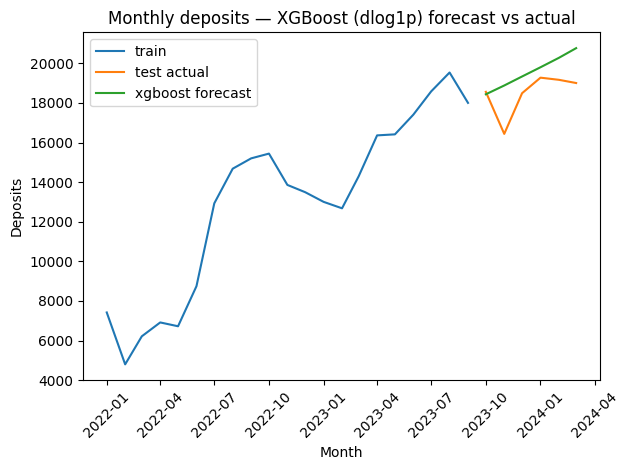

In [46]:

# --- Plot ---
plt.figure()
plt.plot(train_y.index, train_y.values, label="train")
plt.plot(test_y.index, test_y.values, label="test actual")
plt.plot(test_y.index, xgb_pred_test.values, label="xgboost forecast")
plt.title("Monthly deposits — XGBoost (dlog1p) forecast vs actual")
plt.xlabel("Month")
plt.ylabel("Deposits")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [47]:
def fit_xgb_for_explainability(Xtr, ytr, best_params):
    xgb = XGBRegressor(objective="reg:squarederror", random_state=42, **best_params)
    xgb.fit(Xtr, ytr)

    score = xgb.get_booster().get_score(importance_type="weight")
    if len(score) > 0:
        return xgb, "optuna_best"

    # fallback: relax only the params that block splits
    relaxed = dict(best_params)
    relaxed["min_child_weight"] = min(float(relaxed.get("min_child_weight", 1.0)), 3.0)
    relaxed["gamma"] = 0.0
    relaxed["reg_alpha"] = 0.0
    relaxed["reg_lambda"] = max(float(relaxed.get("reg_lambda", 1.0)), 1.0)

    xgb2 = XGBRegressor(objective="reg:squarederror", random_state=42, **relaxed)
    xgb2.fit(Xtr, ytr)
    return xgb2, "relaxed_for_explain"


In [48]:

def plot_xgb_importance_pretty_safe(xgb_model, top_n=15, title=None):
    booster = xgb_model.get_booster()

    # try gain -> weight -> cover
    for imp in ["gain", "weight", "cover"]:
        scores = booster.get_score(importance_type=imp)
        if scores:
            importance_type = imp
            break
    else:
        # nothing worked
        dump0 = booster.get_dump(with_stats=True)[0]
        raise ValueError(
            "No split-based importance available: model has no splits.\n"
            "First tree dump:\n" + dump0[:300]
        )

    items = sorted(scores.items(), key=lambda kv: kv[1], reverse=True)[:top_n]
    feats = [k for k, _ in items]
    vals  = np.array([v for _, v in items], dtype=float)

    fig_h = max(3.0, 0.45 * len(feats) + 1.2)
    fig, ax = plt.subplots(figsize=(10, fig_h), dpi=150)

    norm = (vals - vals.min()) / (vals.max() - vals.min() + 1e-12)
    colors = plt.cm.viridis(norm)

    y = np.arange(len(feats))
    ax.barh(y, vals, color=colors, edgecolor="none")
    ax.set_yticks(y)
    ax.set_yticklabels(feats, fontsize=11)
    ax.invert_yaxis()

    ax.set_xlabel(f"Importance ({importance_type})", fontsize=12)
    ax.set_title(title or f"XGBoost Feature Importance ({importance_type})", fontsize=14)

    xmax = vals.max()
    for i, v in enumerate(vals):
        ax.text(v + 0.01 * xmax, i, f"{v:.3f}", va="center", fontsize=10)

    ax.grid(axis="x", linestyle="--", alpha=0.25)
    plt.tight_layout()
    plt.show()


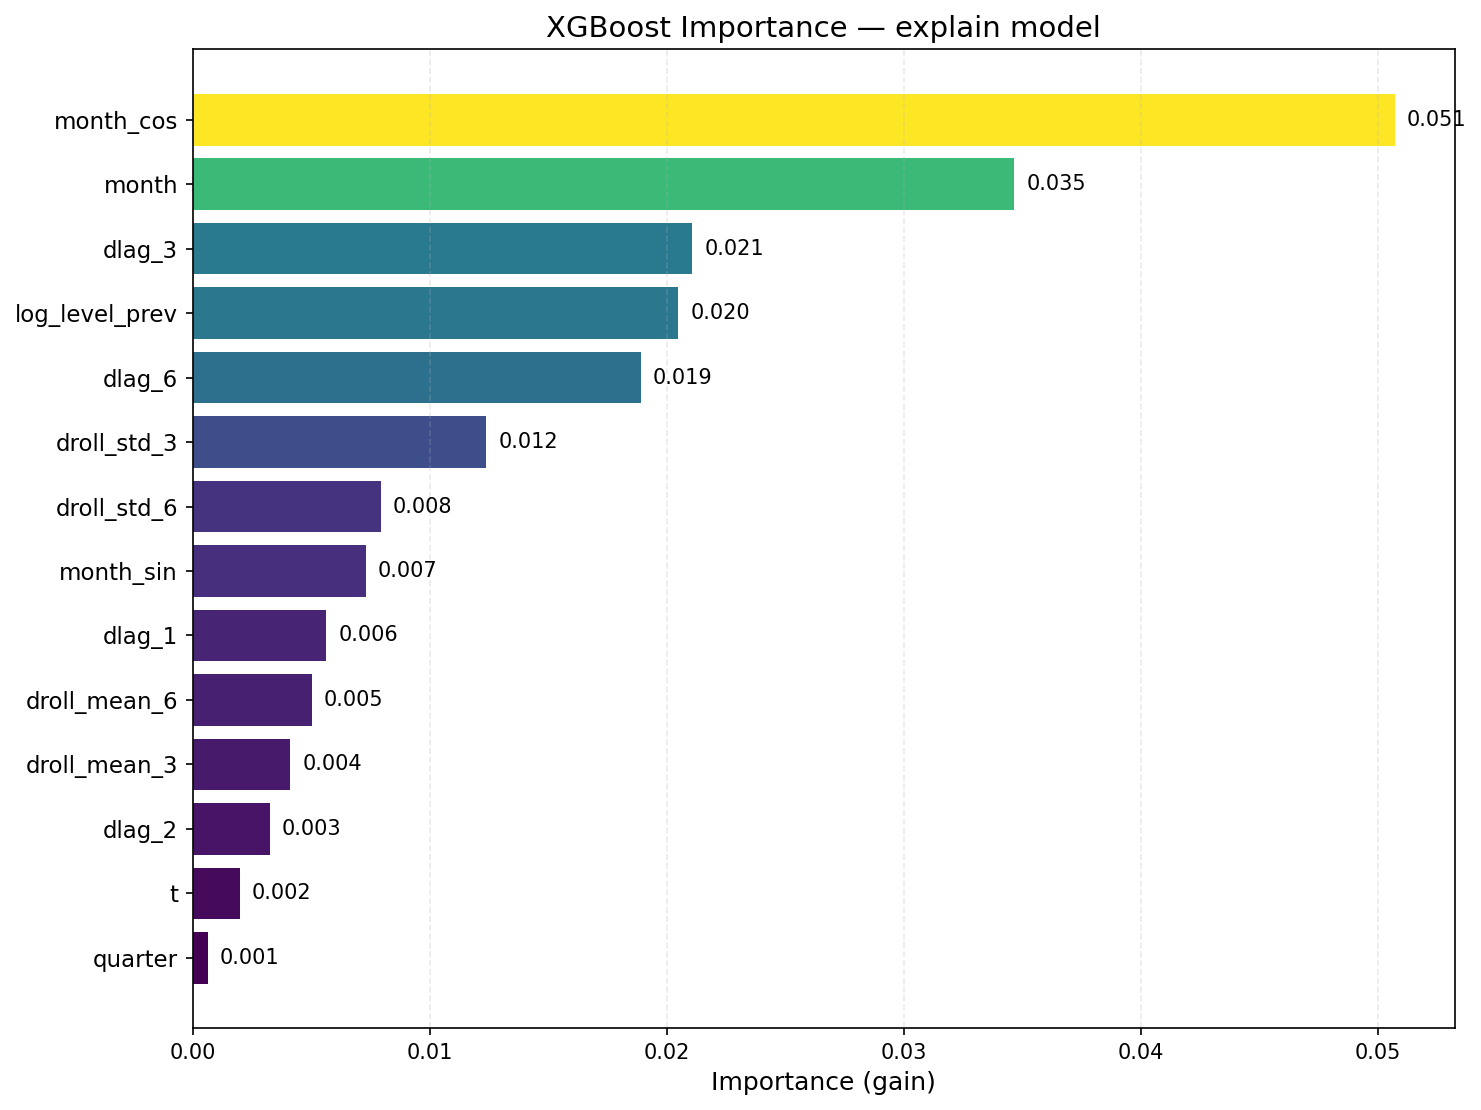

In [49]:
# rebuild the same training matrix
Xtr, ytr, *_ = make_supervised_dlog1p_1step(train_y, lags=(1,2,3,6), rolls=(3,6))

# minimal relax (keep most Optuna params)
relaxed = dict(best_xgb_params)
relaxed["gamma"] = 0.0
relaxed["min_child_weight"] = 1.0
relaxed["reg_alpha"] = 0.0

# remove non-XGB params if stored them together
relaxed.pop("drift_strength", None)
relaxed.pop("clip_pair", None)

xgb_explain = XGBRegressor(objective="reg:squarederror", random_state=42, **relaxed)
xgb_explain.fit(Xtr, ytr)

plot_xgb_importance_pretty_safe(xgb_explain, top_n=20, title="XGBoost Importance — explain model")


In [50]:
def shap_bar_from_booster(xgb_model, X, top_n=20, sample_n=1000, title="SHAP importance"):
    Xs = X.sample(min(sample_n, len(X)), random_state=42)

    booster = xgb_model.get_booster()
    dmat = xgb.DMatrix(Xs, feature_names=list(Xs.columns))

    # SHAP contributions (last column is bias term)
    contrib = booster.predict(dmat, pred_contribs=True)
    shap_vals = contrib[:, :-1]

    mean_abs = np.abs(shap_vals).mean(axis=0)
    order = np.argsort(mean_abs)[::-1][:top_n]

    feats = Xs.columns[order]
    vals = mean_abs[order]

    fig_h = max(3.0, 0.45 * len(feats) + 1.2)
    fig, ax = plt.subplots(figsize=(10, fig_h), dpi=150)

    norm = (vals - vals.min()) / (vals.max() - vals.min() + 1e-12)
    colors = plt.cm.magma(norm)

    y = np.arange(len(feats))
    ax.barh(y, vals, color=colors)
    ax.set_yticks(y)
    ax.set_yticklabels(feats, fontsize=11)
    ax.invert_yaxis()
    ax.set_xlabel("mean(|SHAP|)")
    ax.set_title(title)
    ax.grid(axis="x", linestyle="--", alpha=0.25)
    plt.tight_layout()
    plt.show()

    print("mean(|SHAP|) top features:")
    for f, v in zip(feats, vals):
        print(f"{f:20s} {v:.6f}")


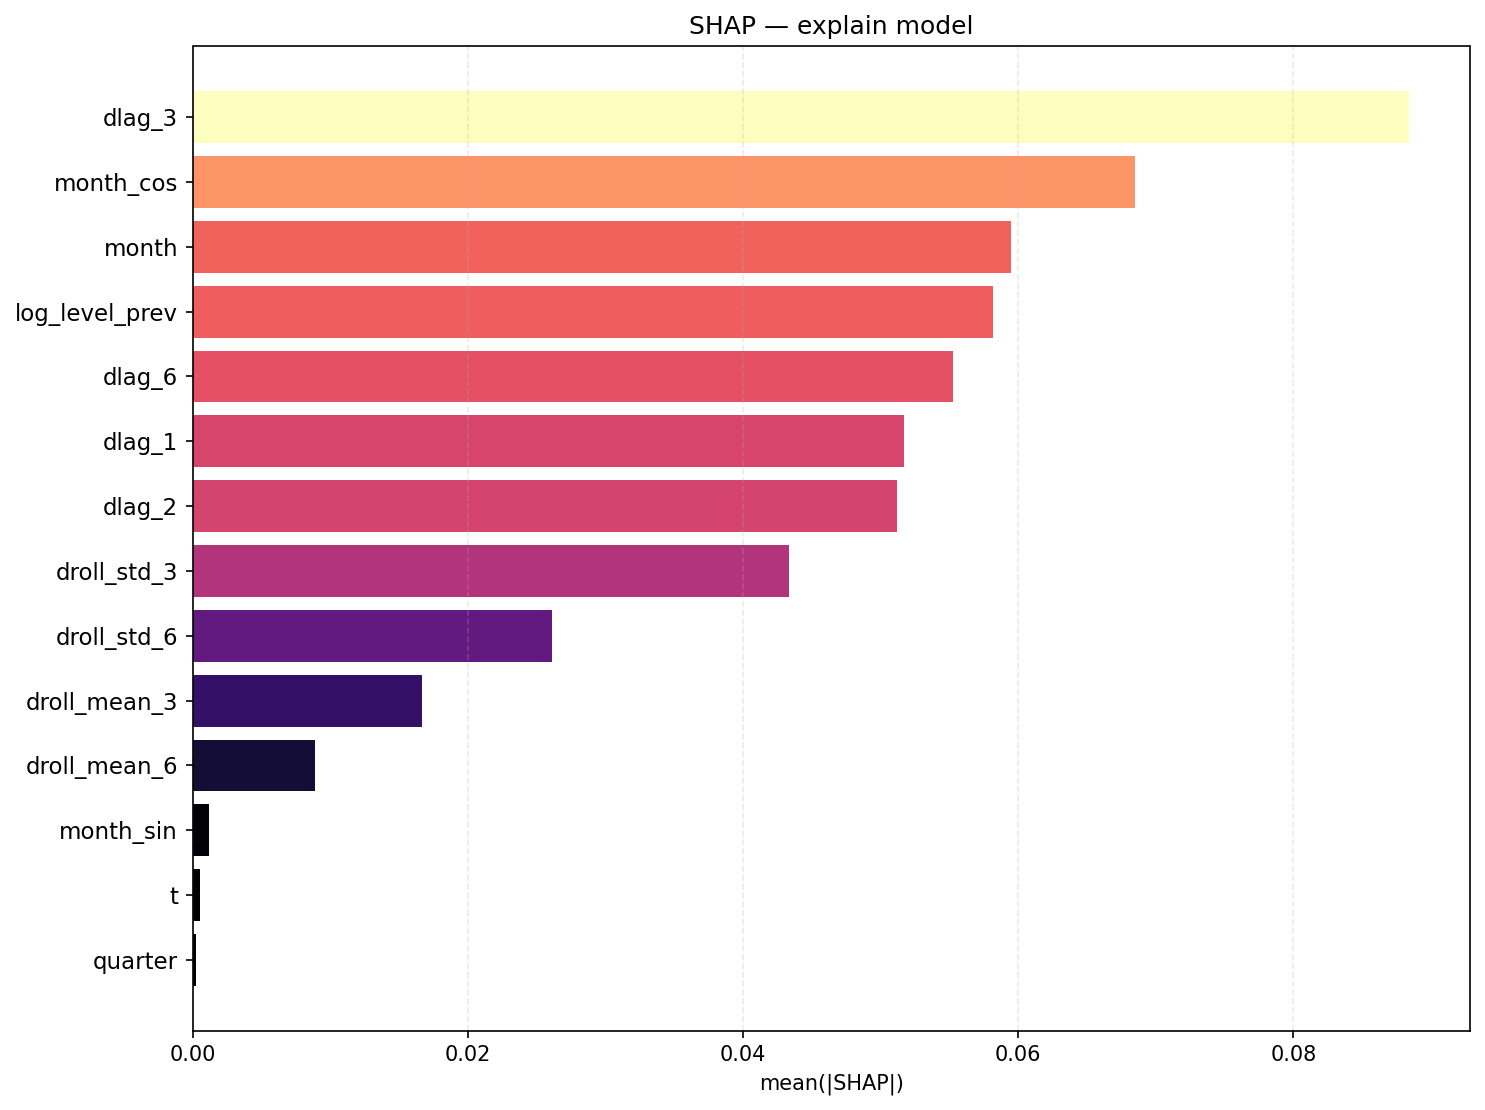

mean(|SHAP|) top features:
dlag_3               0.088415
month_cos            0.068471
month                0.059477
log_level_prev       0.058163
dlag_6               0.055279
dlag_1               0.051709
dlag_2               0.051201
droll_std_3          0.043342
droll_std_6          0.026110
droll_mean_3         0.016701
droll_mean_6         0.008894
month_sin            0.001163
t                    0.000574
quarter              0.000269


In [51]:
# Build Xtr, ytr from the pipeline
Xtr, ytr, *_ = make_supervised_dlog1p_1step(train_y, lags=(1,2,3,6), rolls=(3,6))

explain_params = dict(best_xgb_params)
explain_params.pop("drift_strength", None)
explain_params.pop("clip_pair", None)

# minimal relaxation to ensure splits
explain_params["gamma"] = 0.0
explain_params["min_child_weight"] = 1.0
explain_params["reg_alpha"] = 0.0

xgb_explain = XGBRegressor(objective="reg:squarederror", random_state=42, **explain_params)
xgb_explain.fit(Xtr, ytr)

shap_bar_from_booster(xgb_explain, Xtr, top_n=20, title="SHAP — explain model")


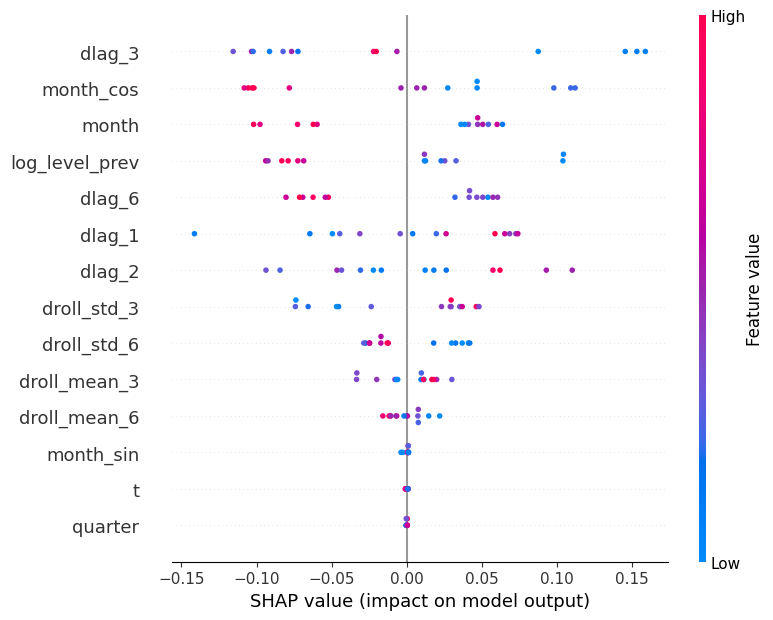

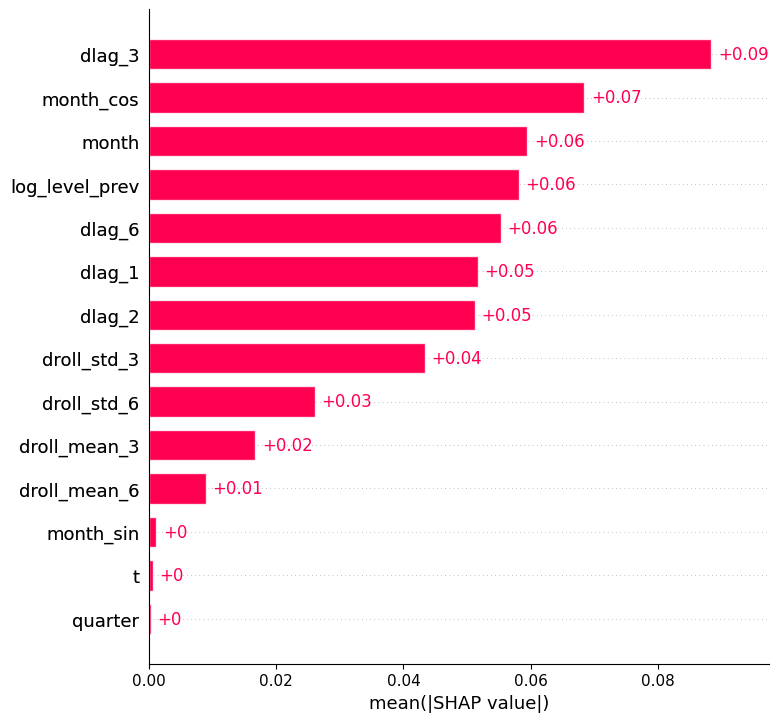

<Figure size 640x480 with 0 Axes>

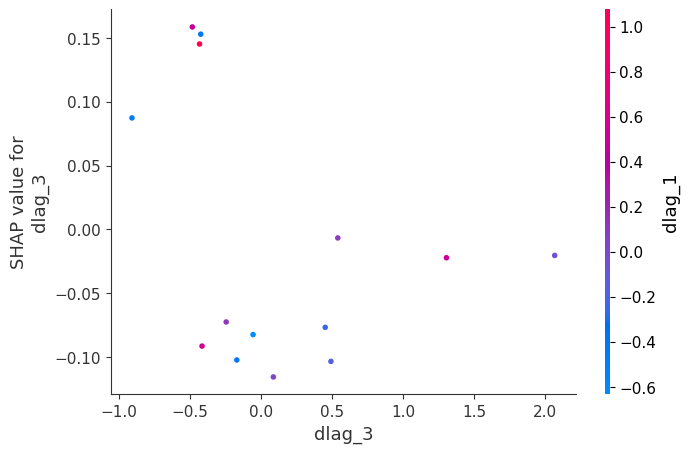

<Figure size 640x480 with 0 Axes>

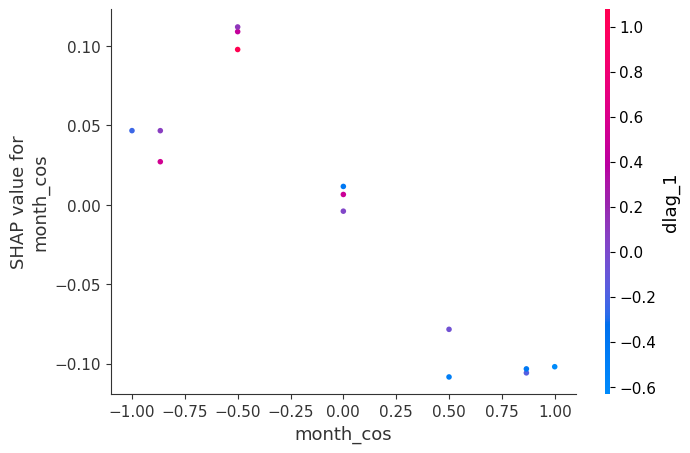

<Figure size 640x480 with 0 Axes>

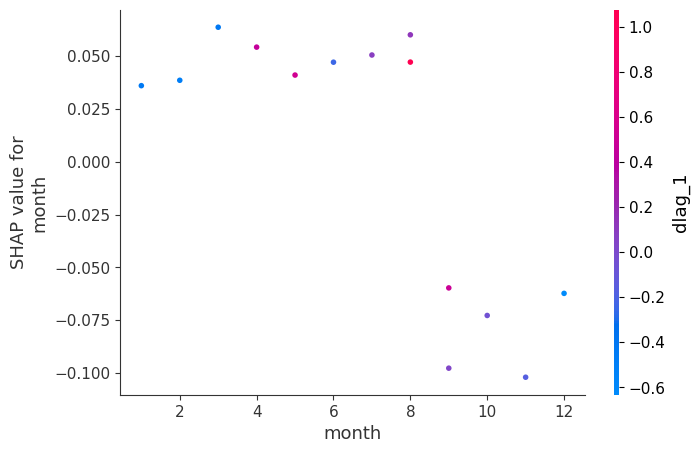

<Figure size 640x480 with 0 Axes>

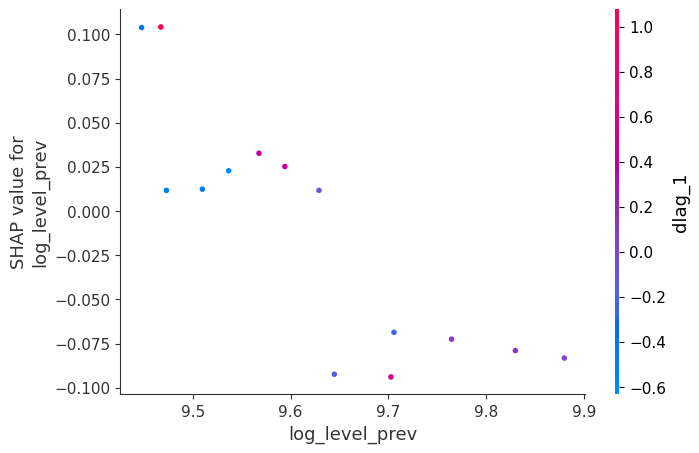

<Figure size 640x480 with 0 Axes>

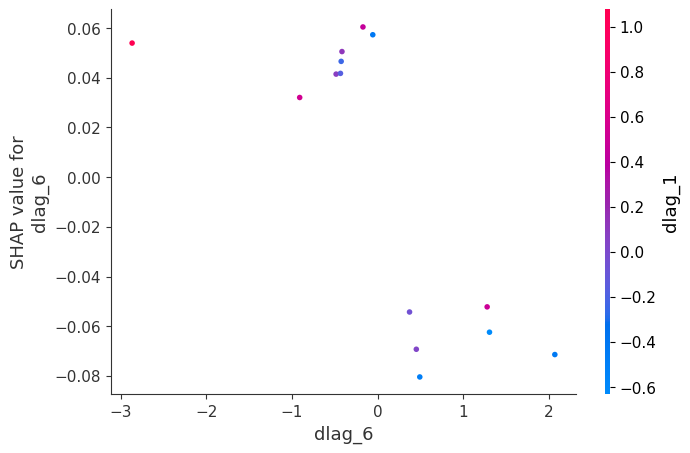

<Figure size 640x480 with 0 Axes>

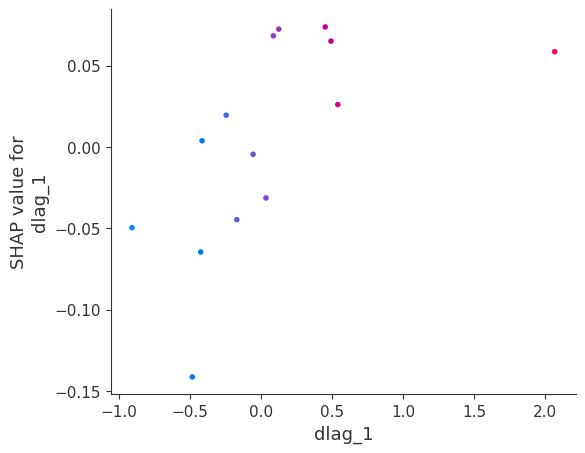

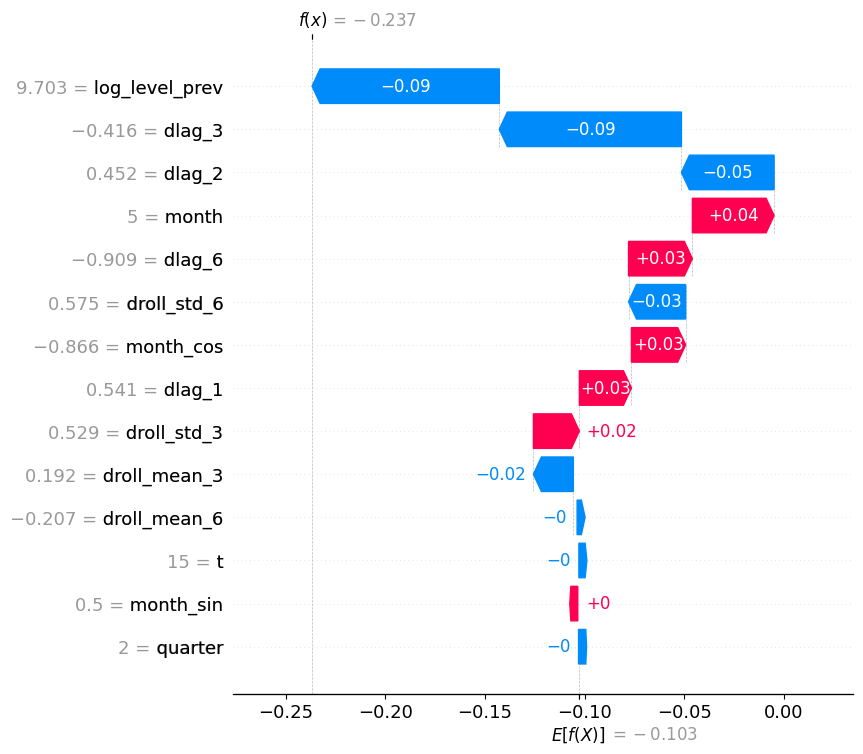


Top features by mean(|SHAP|):
dlag_3               0.088415
month_cos            0.068471
month                0.059477
log_level_prev       0.058163
dlag_6               0.055279
dlag_1               0.051709
dlag_2               0.051201
droll_std_3          0.043342
droll_std_6          0.026110
droll_mean_3         0.016701
droll_mean_6         0.008894
month_sin            0.001163
t                    0.000574
quarter              0.000269


In [52]:
# 
def shap_impact_figures(
    xgb_model,
    X: pd.DataFrame,
    sample_n: int = 800,
    top_n: int = 15,
    title_prefix: str = "XGBoost explain model",
):
    # ---- sample rows for speed/stability ----
    Xs = X.sample(min(sample_n, len(X)), random_state=42)

    # ---- compute SHAP contributions via Booster (robust) ----
    booster = xgb_model.get_booster()
    dmat = xgb.DMatrix(Xs, feature_names=list(Xs.columns))

    contrib = booster.predict(dmat, pred_contribs=True)
    shap_vals = contrib[:, :-1]      # (n, p)
    base_vals = contrib[:, -1]       # (n,)

    # ---- build SHAP Explanation object ----
    exp = shap.Explanation(
        values=shap_vals,
        base_values=base_vals,
        data=Xs.values,
        feature_names=list(Xs.columns),
    )

    # ---- rank top features by mean(|SHAP|) ----
    mean_abs = np.abs(shap_vals).mean(axis=0)
    order = np.argsort(mean_abs)[::-1]
    top_feats = [Xs.columns[i] for i in order[:top_n]]

    # ========== 1) Beeswarm (impact + direction) ==========
    plt.figure()
    shap.plots.beeswarm(exp, max_display=top_n, show=True)

    # ========== 2) Bar (global importance) ==========
    plt.figure()
    shap.plots.bar(exp, max_display=top_n, show=True)

    # ========== 3) Dependence plots (top 4-6 features) ==========
    for feat in top_feats[:6]:
        plt.figure()
        shap.dependence_plot(
            feat,
            shap_vals,
            Xs,
            interaction_index="auto",
            show=True
        )

    # ========== 4) Waterfall for one sample ==========
    i = 0  # change to any index within Xs (0..len(Xs)-1)
    exp_i = shap.Explanation(
        values=shap_vals[i],
        base_values=base_vals[i],
        data=Xs.iloc[i].values,
        feature_names=list(Xs.columns),
    )
    plt.figure()
    shap.plots.waterfall(exp_i, max_display=top_n, show=True)

    # print top features table
    print("\nTop features by mean(|SHAP|):")
    for f in top_feats[:top_n]:
        j = Xs.columns.get_loc(f)
        print(f"{f:20s} {mean_abs[j]:.6f}")

# ---- Usage ----
# xgb_explain (fitted) and Xtr (features used for fit)
shap_impact_figures(
    xgb_explain,
    Xtr,
    sample_n=800,
    top_n=15,
    title_prefix="XGB explain"
)


### XGBoost (dlog1p) — Rolling CV Results, Holdout Behavior, and Why the “Dip” Is Hard to Capture

#### 1) What the model is doing (1–2 lines)
We recast monthly deposits into a supervised learning task where the **target** is next month’s **log-change (dlog1p)**. The model learns from **momentum (lags)**, **volatility (rolling stats)**, **level (previous log level)**, and **calendar signals**, and produces a 6-month forecast **recursively** (a 1-step model rolled forward).

#### 2) Rolling CV summary — XGBoost vs baselines (actual numbers)

Rolling-CV mean (**4 folds × 6-month horizon**):

| Model | MAE | RMSE | WAPE | MASE |
|---|---:|---:|---:|---:|
| **XGBoost (dlog1p)** | **2979.62** | **3309.43** | **0.1802** | **2.272** |
| **naive (last month)** | 3218.21 | 3561.79 | 0.1936 | 2.458 |
| **seasonal_naive (t-12)** | 7761.41 | 7986.92 | 0.4756 | 5.847 |

**Interpretation**
- **MAE improves** 3218 → 2980 (**~7.4% lower**).
- **WAPE improves** 19.36% → 18.02% (**~6.9% better**).
- **MASE improves** 2.46 → 2.27, but remains **> 1**, meaning the series is still **hard/volatile** even though XGBoost is better on average.

**Stakeholder sentence**
> “With a log transform and lag/rolling feature engineering, XGBoost beats the ‘last-month’ baseline by ~7% on rolling backtests (WAPE 18.0% vs 19.4%).”

#### 3) Fold-by-fold behavior (sanity check narrative)
Across folds:
- **Folds 1–3:** XGBoost performance is extremely close to the naive baseline.
- **Fold 4:** XGBoost clearly improves versus naive (e.g., WAPE ~13.9% vs ~19.3%).

**Why this matters:** When an ML model matches a baseline very closely across multiple folds, it’s worth verifying whether (a) early folds have too few training rows after lag/rolling feature creation, or (b) the evaluation wrapper defaults to a naive-like behavior under certain conditions. Either way, the overall conclusion remains: **XGBoost is best on average**, and improvements are strongest when there is enough signal/history.

#### 4) Why `seasonal_naive` is poor here (and why that’s a good finding)
`seasonal_naive` predicts **this month = same month last year (t-12)**. It performs badly because deposits show a **strong upward shift / level change** year-over-year, so “same month last year” is systematically off.  
This is a useful stakeholder takeaway: **the process is not stable YoY**, so seasonal baselines are not appropriate without detrending or adding drivers.

#### 5) Holdout behavior — why the forecast looks smooth and misses the dip
On the holdout plot, XGBoost tracks **trend and level**, but **doesn’t drop enough** during the dip. This is expected because:

- **Recursive multi-step forecasting smooths shocks**: rolling a 1-step model forward tends to drift toward typical behavior and underreact to sudden reversals.
- **Conservative tuning** (e.g., strong drift strength and clipping of extreme log-changes) makes the model less willing to predict sharp drops/spikes.
- **No exogenous drivers**: if dips are caused by campaigns, acquisition mix, payment incidents, policy changes, etc., lag-only models typically can’t anticipate them.
- **Small data**: ~27 months is limited, especially if “dip” events are rare.

**Conclusion:** the dip is hard to capture mainly due to **short history + missing drivers + recursive smoothing**.

#### 6) SHAP — what it means in business terms (3 figures)

##### A) SHAP beeswarm (global importance)
**What it shows:** The model is driven mainly by:
- **Momentum features** (e.g., `dlag_1`, `dlag_3`, `dlag_6`)
- **Volatility regime** (e.g., `droll_std_3`, `droll_std_6`)
Calendar terms (`month_sin/cos`, `month`) matter, but are **secondary**.

**Business meaning:** Deposits behave more like a **momentum + volatility** process than a stable seasonal cycle. This supports prioritizing monitoring of **recent growth/decline** and **volatility spikes** as key risk signals.

##### B) SHAP waterfall (single prediction explanation)
**What it shows:** For a specific month’s forecast, the prediction is mostly explained by:
- **Recent momentum (especially ~3 months back)**
- **Current level** (where the series is on the overall trend)
with smaller calendar adjustments.

**Business meaning:** “Recent momentum weakened and deposits are already at a high level → expected growth slows; seasonality provides only a small offset.”  
This is useful for stakeholder trust: the model’s reasoning is interpretable and aligns with common business intuition.

##### C) SHAP interaction/scatter (volatility vs impact)
**What it shows:** Volatility features can have **different impacts depending on recent momentum** (e.g., volatility becomes more negative when momentum is already down).

**Business meaning:** In a volatile regime, outcomes depend strongly on whether momentum is up or down. Operationally, this supports tracking **momentum + volatility jointly** (e.g., “high volatility + negative momentum” as an early warning pattern).


#### Summary
- **XGBoost improves on naive by ~7%** on rolling CV (WAPE **18.0%** vs **19.4%**).
- Forecasts look smooth and miss dips due to **recursive horizon + conservative tuning + missing drivers + short history**.
- SHAP supports a clear business narrative: predictions are driven mainly by **momentum and volatility regime**, while **seasonality is weaker**—so improving dip capture likely requires **exogenous signals** (e.g., FTD, active users, registrations, campaign/affiliate flags).


### Forecast granularity: global vs brand-level (hierarchical)

#### Step 0 — Definitions (what “global” vs “brand-level” means here)

The raw dataset is **user-level transactional data**: each row corresponds to a `(date, brand, user_id)` with `deposit_amount` (and other activity fields).

We can aggregate this into monthly time series at two levels:

**Global monthly deposits** (single series):
$$
Y_{\text{global},t}=\sum_{b\in\mathcal{B}}\sum_{u\in\mathcal{U}_{b,t}} \text{deposit\_amount}_{u,b,t}
$$

**Brand monthly deposits** (one series per brand \(b\)):
$$
Y_{b,t}=\sum_{u\in\mathcal{U}_{b,t}} \text{deposit\_amount}_{u,b,t}
$$

So:
- **Global** = 1 time series (monthly total)
- **Brand-level** = multiple time series (one per brand: L, S, J)

#### Step 1 — Do we need separate forecasting models per brand?

Not necessarily. There are three standard approaches:

**A) Global-only**
- Forecast only \($Y_{\text{global},t}$\).
- Use when decisions focus on total cash flow.

**B) Brand-only (bottom-up)**
- Forecast each \($Y_{b,t}$\) separately (e.g., \($Y_{L,t}, Y_{S,t}, Y_{J,t}$\)).
- Global is then computed as:
$$
\widehat{Y}_{\text{global},t}=\sum_{b\in\mathcal{B}} \widehat{Y}_{b,t}
$$
- Risk: small/volatile brands are noisy; the summed forecast can be unstable.

**C) Both (hierarchical)**
- Forecast \($Y_{\text{global},t}$\) (robust and usually most accurate),
- Also output brand forecasts for actionability,
- Ensure **coherence** (brand forecasts add up to global).

#### Step 2 — Evidence from data: brand share stability

Define each brand’s monthly share:
$$
s_{b,t}=\frac{Y_{b,t}}{Y_{\text{global},t}}
$$

From the training data, estimated brand share stability (mean share and CV):

- **L**: mean share \($\approx 0.896$\), CV \($\approx 0.075$\) → **very stable and dominant**
- **S**: mean share \($\approx 0.104$\), CV \($\approx 0.646$\) → **small and volatile**
- **J**: mean share \($\approx 0.00022$\), CV \($\approx 3.50$\) → **negligible and extremely unstable**

**Interpretation:** the global series is overwhelmingly driven by brand **L**, and L’s share is stable. In contrast, S/J are small and noisy, making independent brand modeling less reliable.

#### Step 3 — Top-down allocation (how to get brand forecasts without per-brand models)

We first forecast the **global** series:
$$
\widehat{Y}_{\text{global},t}
$$

Then estimate a recent average brand share \(\bar{s}_b\) from the last \(K\) training months, and allocate:
$$
\widehat{Y}_{b,t}=\bar{s}_b \cdot \widehat{Y}_{\text{global},t}
$$

This produces brand-level forecasts **without fitting separate models** for each brand.

#### Step 4 — Accuracy: brand-level WWAPE (top-down vs bottom-up)

To compare brand-level accuracy, we use **WWAPE** (volume-weighted absolute percentage error):
$$
\text{WWAPE}=\frac{\sum_{b}\sum_{t} |Y_{b,t}-\widehat{Y}_{b,t}|}{\sum_{b}\sum_{t} |Y_{b,t}|}
$$

Results on the test period:
- **Top-down WWAPE** \(= 0.2134\)
- **Bottom-up seasonal-naive WWAPE** \(= 0.2635\)

**Conclusion:** deriving brand forecasts from the global model via top-down allocation is **more accurate** than forecasting each brand independently using a simple per-brand baseline.

#### Step 5 — Coherence: why “both” matters for reporting/finance

Coherence means:
$$
\sum_{b\in\mathcal{B}} \widehat{Y}_{b,t} = \widehat{Y}_{\text{global},t}
$$


In [53]:

DATE_COL  = "date"
BRAND_COL = "brand"
Y_COL     = "deposit_amount"   # or "net_deposit"

def to_month_start(x):
    dt = pd.to_datetime(x)
    if isinstance(dt, pd.DatetimeIndex):
        return dt.to_period("M").to_timestamp(how="start")
    else:
        return dt.dt.to_period("M").dt.to_timestamp(how="start")

def wwape(actual_df: pd.DataFrame, pred_df: pd.DataFrame) -> float:
    num = float((actual_df - pred_df).abs().sum().sum())
    den = float(actual_df.abs().sum().sum())
    return num / den if den != 0 else np.nan

def coherence_gap(pred_brand_df: pd.DataFrame, global_forecast: pd.Series) -> dict:
    sum_brand = pred_brand_df.sum(axis=1).reindex(global_forecast.index)
    gf = global_forecast.reindex(sum_brand.index).replace(0, np.nan)
    gap = (sum_brand - gf) / gf
    return {"mean_abs_gap": float(gap.abs().mean()), "max_abs_gap": float(gap.abs().max())}

# --- monthly brand pivot ---
df2 = df.copy()
df2[DATE_COL] = to_month_start(df2[DATE_COL])

monthly = (
    df2.groupby([DATE_COL, BRAND_COL], as_index=False)[Y_COL]
       .sum()
)

brand_pivot = monthly.pivot(index=DATE_COL, columns=BRAND_COL, values=Y_COL).sort_index()

train_idx = pd.DatetimeIndex(train_y.index)
test_idx  = pd.DatetimeIndex(test_y.index)

brand_train = brand_pivot.reindex(train_idx)
brand_test  = brand_pivot.reindex(test_idx)

brands = list(brand_pivot.columns)

# --- 1) Share CV table ---
total_train = brand_train.sum(axis=1)
share_train = brand_train.div(total_train, axis=0)

share_stats = pd.DataFrame({
    "mean_share": share_train.mean(skipna=True),
    "std_share":  share_train.std(skipna=True),
})
share_stats["cv_share"] = share_stats["std_share"] / share_stats["mean_share"]
share_stats = share_stats.sort_values("cv_share")

print("\n--- Brand share stability (lower CV => more stable) ---")
display(share_stats)

# --- 2) Top-down allocation forecast (use the global forecast series) ---
# choose which global forecast to justify (xgb_pred_test / sarimax_pred_test / lstm_pred_test)
global_fc = xgb_pred_test.reindex(test_idx)

K = 6  # last K months to estimate brand shares
recent_shares = share_train.tail(K).mean(skipna=True).fillna(0.0)
recent_shares = recent_shares / recent_shares.sum() if recent_shares.sum() > 0 else recent_shares

pred_topdown = pd.DataFrame(index=test_idx, columns=brands, dtype=float)
for b in brands:
    pred_topdown[b] = global_fc.values * float(recent_shares.get(b, 0.0))

# --- 3) Bottom-up seasonal naive brand forecast (baseline) ---
SEASONAL_LAG = 12
pred_bottomup_seas = pd.DataFrame(index=test_idx, columns=brands, dtype=float)

for b in brands:
    s_full = brand_pivot[b].copy().sort_index()
    pred = s_full.shift(SEASONAL_LAG).reindex(test_idx)

    last_train_val = brand_train[b].dropna().iloc[-1] if brand_train[b].dropna().shape[0] > 0 else 0.0
    pred_bottomup_seas[b] = pred.fillna(float(last_train_val)).values

# --- 4) WWAPE comparison on brand totals ---
actual_brand = brand_test.fillna(0.0)
topdown_wwape = wwape(actual_brand, pred_topdown.fillna(0.0))
bottomup_wwape = wwape(actual_brand, pred_bottomup_seas.fillna(0.0))

print("\n--- Brand-level WWAPE (lower is better) ---")
print(f"Top-down (global→brand via shares) WWAPE: {topdown_wwape:.4f}")
print(f"Bottom-up seasonal naive (brand) WWAPE:  {bottomup_wwape:.4f}")

# --- 5) Coherence gap metrics ---
print("\n--- Coherence gap vs global forecast ---")
print("Top-down gap (≈0 by construction):", coherence_gap(pred_topdown, global_fc))
print("Bottom-up seasonal gap:", coherence_gap(pred_bottomup_seas, global_fc))



--- Brand share stability (lower CV => more stable) ---


,mean_share,std_share,cv_share
brand,,,
L,0.895700,0.067519,0.075381
S,0.104153,0.067297,0.646138
J,0.000221,0.000773,3.503674



--- Brand-level WWAPE (lower is better) ---
Top-down (global→brand via shares) WWAPE: 0.2141
Bottom-up seasonal naive (brand) WWAPE:  0.2635

--- Coherence gap vs global forecast ---
Top-down gap (≈0 by construction): {'mean_abs_gap': 1.5319149424966645e-16, 'max_abs_gap': 1.9268508872946913e-16}
Bottom-up seasonal gap: {'mean_abs_gap': 0.2929306086657713, 'max_abs_gap': 0.37480563502213854}



Observed coherence gaps:
- **Top-down:** mean/max gap \($\approx 0$\) (numerically ~\($10^{-16}$\)) → **perfectly coherent**
- **Bottom-up seasonal:** mean gap \($\approx 0.29$\), max gap \($\approx 0.37$\) → **large inconsistency**

**Interpretation:** independent brand forecasts can sum to a total that differs from the global forecast by ~30%, which is problematic for planning and finance reporting. Top-down avoids this by construction.

Summary:
- Brand **L** dominates and is stable (CV \($=0.075$\)),
- Top-down improves brand-level accuracy (WWAPE \($0.2134$\) vs \($0.2635$\)),
- Top-down is coherent (gap \($\approx 0$\) vs \($\approx 0.29$\)),

**I would forecast monthly deposits at the global level using the best-performing univariate model (e.g., SARIMAX(dlog1p) or LSTM(dlog1p)) and provide brand-level forecasts using a hierarchical top-down allocation.**  
This delivers both a robust total forecast and actionable brand splits, while preserving additivity and minimizing noise from small/volatile brands (S/J).

### Assumptions, limitations, and uncertainty

#### Assumptions
- **Business structure is stable:** Brand **L** drives ~90% of deposits and its share is stable (**CV ≈ 0.075**). We assume near-term totals will continue to be dominated by **L**.
- **Recent brand mix is a reasonable guide:** For top-down brand allocation, we assume recent brand shares (e.g., last **6 months**) are representative of the forecast horizon.
- **No major structural breaks:** We assume no major changes in promotions, payment methods, product, regulation, or tracking that would materially shift deposit behavior during the forecast window.

#### Limitations
- **Small dataset / short history:** Monthly history is limited, so models may struggle to learn robust seasonality and to generalize to rare events.
- **Small and noisy brands:** Brands **S** and especially **J** have low volume and high share variability (**CV ≈ 0.65** and **3.50**). Independent brand forecasting is therefore unstable and noisy.
- **Univariate signal only:** Forecasting used mainly deposit history. Without external drivers (promotions, acquisition spend, VIP events, macro/seasonal campaigns), sudden dips/spikes are inherently hard to predict.

#### Uncertainty
- **Global forecast intervals:** Use SARIMAX prediction intervals to provide a range (e.g., **80%** and **95%**) rather than a single point estimate.
- **Brand uncertainty has two sources:** Brand forecasts reflect:
  - global forecast error, and  
  - brand mix variability (higher uncertainty for **S/J**).
- **Decisions should use ranges:** For planning, use the forecast range (base / downside / upside) rather than only the point forecast.


---

### 5. Production implementation (end-to-end)

#### Summary (what runs in production)
A scheduled pipeline pulls data from the DWH, builds curated monthly “gold” tables, trains/validates a **global deposits forecaster** (plus fallback), produces **global + brand-level forecasts** (via top-down allocation when shares are stable), writes results back to the DWH for dashboards, and continuously monitors **accuracy + drift (PSI)** to trigger controlled retraining under a champion–challenger setup.

#### A) Data flow (DWH → modeling-ready tables)
- **Inputs (DWH / lakehouse)**
  - Transaction/user tables: deposits, withdrawals, bets/wins, registrations, affiliates, brand
- **Transform (ELT in dbt/SQL) → “gold” tables**
  - `fact_monthly_deposits_global` (month → total deposits)
  - `fact_monthly_deposits_brand` (month, brand → deposits)
  - *(optional)* `fact_user_features_daily/weekly` (for churn/LTV expansions)
- **Data quality & consistency**
  - Freshness, null/duplicate checks, schema drift, outlier guards
  - Unit checks: historical `global = sum(brands)` (coherence on actuals)

**Output:** versioned, audited datasets ready for training and scoring.

#### B) Modeling layer (train + validate + select champion)
- **Model candidates**
  - Baselines: seasonal naïve / moving average (always kept as fallback)
  - Classical: **SARIMAX** (good for small data + prediction intervals)
  - ML: **XGBoost** (lags/rolling/calendar + exogenous drivers if available)
  - Deep learning (when history + features are large):  
    - LSTM/xLSTM, Temporal Convolution (TCN)  
    - **Time-series Transformers / foundation models** (for many related series / long history)
- **Time-safe evaluation**
  - Rolling CV (expanding window)
  - Metrics: WAPE/MAE + interval coverage (when using SARIMAX/quantile models)
- **Hierarchy strategy (global vs brand)**
  - Train **global** forecast as primary (robust)
  - Produce **brand forecasts** via top-down allocation when shares are stable
  - If enough brand data: add brand models and reconcile later (hierarchical consistency)

**Output:** champion model + fallback + documented selection criteria.

#### C) Deployment & inference (batch scoring)
- **Packaging**
  - Containerized Python service/package with stable interface:
    - `train()` → produces versioned model artifact
    - `predict(horizon)` → writes forecasts to DWH tables
- **Orchestration**
  - Airflow / Prefect / Dagster:
    - feature refresh (daily/weekly if needed)
    - forecast run (monthly)
- **Serving pattern**
  - Batch outputs written to:
    - `forecast_monthly_global` (point forecast + optional intervals)
    - `forecast_monthly_brand` (brand splits + coherence guarantee)

**Output:** forecasts available to Finance/Ops dashboards with an SLA.

#### D) Monitoring, drift detection, retraining triggers
- **Accuracy monitoring**
  - Track MAE/WAPE by horizon once actuals arrive
  - Alert if degradation crosses thresholds
- **Data drift monitoring**
  - PSI (Population Stability Index) on key drivers/features (and/or residual distribution)
  - Example policy:
    - PSI $<$ 0.10: stable
    - 0.10–0.25: monitor
    - $>$ 0.25: investigate / retrain
- **Retraining triggers**
  - PSI threshold exceeded, or
  - sustained error increase, or
  - known business events (promo/regulation/payment changes)

**Output:** controlled updates instead of silent model decay.

#### E) Governance & reliability
- Version everything: training data snapshot, code, params, model artifact
- Champion–challenger + rollback (fallback baseline always available)
- Explainability:
  - XGBoost: feature importance/SHAP (stakeholder-friendly drivers)
  - SARIMAX: prediction intervals for risk-aware planning


#### F) Where Transformers / “LLM-style” models fit (practical)
- **Numeric forecasting engine (when it has much larger history / many series):**
  - Consider TS foundation models such as **TimesFM, Chronos, Lag-Llama, Moirai**
  - Use **fine-tuning** when it has sufficient historical breadth (many related series across brands/markets) and need domain alignment
- **LLM + RAG / GraphRAG (not the numeric predictor)**
  - **RAG**: generate “forecast narrative” and scenario notes by retrieving promo calendars, incident logs, finance notes
  - **GraphRAG**: connect brand ↔ affiliate ↔ campaign ↔ geo/payment changes to support anomaly root-cause and consistent explanations
  - Output: stakeholder-ready commentary + risk flags, paired with the numeric forecast

### One-sentence stakeholder version
“Every month we refresh clean deposit tables from the DWH, run a validated global forecasting model with coherent brand splits, publish results to dashboards, and monitor both accuracy and drift (PSI) to retrain safely when the data regime changes.”


---

### 6. Conclusions & Recommendations

#### Key findings (what we learned)
- **Global vs brand-level:** Deposits are highly concentrated in **brand L** (mean share ≈ **0.896**) and its share is **stable** (CV ≈ **0.075**). In practice, the **global** deposits series is largely driven by brand L behavior.
- **Best practical forecasting approach for this dataset:** A **global forecast + top-down brand allocation** is the most robust option:
  - **Brand-level accuracy:** Top-down **WWAPE = 0.213** vs bottom-up seasonal naive **WWAPE = 0.264**
  - **Financial consistency (“coherence”):** Top-down is coherent by design (**gap ≈ 0**), while bottom-up can diverge materially (mean coherence gap ≈ **0.29**, max ≈ **0.37**).
- On this short monthly series, all models mainly learn the same upward trend and produce smooth forecasts; none reliably captures sudden dips. In rolling backtests, XGBoost provides a small but consistent improvement over the naive baseline (~7% WAPE lift), whereas LSTM does not beat naive on average, suggesting model choice is less important than adding exogenous drivers and more history.  
  **However, XGBoost adds clear value for interpretability**, helping explain *why* deposits move month to month.

#### What the XGBoost explainability says (SHAP/importance → business interpretation)
From the **XGBoost “explain model”** (used for interpretation, not necessarily the champion forecaster), the key drivers were:
- **Seasonality / calendar effects dominate:**  
  `month` and `month_cos` are top features → deposits follow a strong seasonal pattern (certain months systematically higher/lower).
- **Short-term momentum matters:**  
  `dlag_3`, `dlag_1`, `dlag_2` are important → recent changes in deposits (last 1–3 months) strongly influence next month.
- **Volatility regime matters:**  
  `droll_std_6` (6-month rolling volatility) is important → when deposits become more volatile, the next-month outcome shifts meaningfully.
- **Current scale matters (level effect):**  
  `log_level_prev` matters → higher recent deposit levels tend to carry forward (but can also mean reversion depending on SHAP direction).

**Stakeholder-friendly translation:**  
> “Deposits are driven mainly by seasonality plus short-term momentum. When the business enters a high-volatility period, forecasts become more uncertain and deviations from trend are more likely.”

#### Recommendations (business actions)
**1) Use global forecasting for planning, and brand splits for actionability**
- Use the **global forecast + prediction intervals** for **cash planning / liquidity / budgeting**.
- Allocate global totals into brands using recent shares so that **brand targets always reconcile to the total** (no reporting mismatch).

**2) Focus effort where the impact is largest: brand L**
Because L contributes ~90% of deposits, even small improvements in L outperform large efforts on S/J.
- Treat brand L as the “primary lever” for growth and stability.
- Track and explain L’s month-to-month changes using:
  - seasonality calendar (`month` effects),
  - recent momentum signals (last 1–3 months),
  - volatility regime (rolling std).

**3) Operationalize “seasonality + momentum” into actions**
Based on the SHAP findings:
- **Seasonality-driven planning:** pre-plan campaigns, VIP events, and staffing around historically strong/weak months.
- **Momentum-driven triggers:** if the last 1–3 months show consistent up/down movement, treat it as an early indicator for next month.
- **Volatility escalation playbook:** when volatility rises (high `droll_std_6`), tighten monitoring and move from single forecasts to scenario ranges.

**4) Treat S/J as monitoring rather than heavy modeling (for now)**
- Brand S is small and volatile; brand J is tiny and extremely unstable.
- Recommended approach:
  - use share monitoring + anomaly alerts,
  - only build separate per-brand models once volume/history is sufficient.

**5) Make uncertainty explicit**
- Report forecasts as **base / downside / upside** (e.g., SARIMAX 80% / 95% intervals).
- Use ranges for decisions (campaign budget, buffer sizing), not point estimates only.

#### What I would improve with more time or additional data

**Data improvements (biggest payoff)**
- Add external/operational drivers to improve accuracy and explainability:
  - promotion calendar, affiliate spend, VIP events, payment incidents, regulatory changes, acquisition campaigns.
- Increase history length (more months/years) and/or move to weekly/daily to better learn seasonality and detect shocks earlier.
- Build a consistent feature layer (“feature store”) for brand/affiliate/user rollups.

**Modeling improvements (with more time and/or additional data)**

- **Key point upfront:** More data *helps*, but it does **not** automatically make “dip prediction” easy — dips are often **event-driven** (campaign changes, affiliate shifts, payout/ops incidents, regulation). The biggest gains typically come from adding **exogenous drivers** and changing the **multi-step strategy** to reduce smoothing.

- **Reduce multi-step smoothing (improves turning points):**
  - **Direct multi-step XGBoost (h = 1..6 or 12):**
    - train one model per horizon (each horizon learns its own mapping)
    - avoids error snowballing from recursive predictions
    - often improves timing/magnitude around turning points
    - **initial trials** are included in the **Appendix** (not an exhaustive sweep of all feature/parameter combinations)
    - next steps: expand the search (more horizons/feature sets/hyperparams) and re-run with more data to validate stability and reduce variance
  - **Seq2Seq deep forecasting (LSTM/Transformer):**
    - predict the full horizon vector `[t+1..t+6]` in one shot
    - reduces recursive drift and can learn “shape patterns” (dip/rebound)
    - still needs careful regularization and/or covariates

- **Add the drivers that create dips (most important for real dip capture):**
  - marketing/campaign calendar, bonus spend, affiliate activity + mix
  - monthly actives / FTD counts / registrations / churn proxies
  - payment incidents, payout delays, product/regulatory changes  
  -> This turns “unexpected dips” into **explainable, learnable** patterns instead of pure noise.

- **Make the model regime-aware (normal vs stressed months):**
  - **quantile forecasts / prediction intervals** to quantify downside risk even if the median stays smooth
  - **regime switching / change-point features** to flag “stress” periods
  - evaluation that emphasizes dip months (weighted loss / asymmetric penalties)

- **Move from “global + top-down” to a full hierarchical forecasting setup (when dataset grows):**
  - forecast **brands/segments** where data supports it
  - reconcile brand forecasts so they sum to the global total (**coherent reporting**)

- **For larger scale and many related series, consider multi-series models:**
  - **xLSTM / time-series Transformers**
  - **time-series foundation models (TimesFM / Chronos / Lag-Llama / TimeGPT)** for many brands/markets/segments and longer history  
  *(These can improve generalization across related series, but dip-capture still benefits most from driver features + regime handling.)*

**Broader analytics beyond forecasting (more business leverage)**
- Extend into **churn** (classification) and **CLV/LTV** (regression) using user-level sequences.
- Combine **frequentist + Bayesian** approaches:
  - frequentist for scalable production scoring,
  - Bayesian for uncertainty-aware planning and experiment decisions (uplift, marketing ROI).

#### Closing statement
Given current data constraints, the most reliable and operationally consistent solution is a **global monthly deposits forecast** paired with **top-down brand allocation**, with explicit uncertainty ranges. The explainability results show deposits are mainly driven by **seasonality, recent momentum, and volatility regime**, which can be translated into practical planning and monitoring actions. As data grows, this framework naturally scales into **multi-series brand forecasting**, richer driver-based modeling, and user-level **churn/CLV** to support retention and growth.


---

### Appendix: Direct Multi-Step XGBoost + Dip-Probability Blending (Regressor + Classifier Mixture)

The earlier experiments showed that SARIMAX, LSTM, and XGBoost produce similar, smooth forecasts on this short monthly series and tend to miss the same "dip month." This appendix documents an experimental, dip-aware approach that explicitly combines:

- A **regression model** (predicts how much), and
- A **classification model** (predicts whether a dip is likely)

Then blends outputs into a single forecast. This is essentially a mixture-of-experts idea:

- **Regressor (mean)** → best single-point estimate
- **Regressor (downside quantile)** → "dip-risk" scenario
- **Classifier (dip probability)** → when to trust the downside more than the mean
- **Blending rule** → shifts the forecast toward downside when dip probability is high

This is mainly useful for **risk-aware planning** (base vs downside scenario). On small data, it may not improve point accuracy, but it provides a structured way to incorporate dip risk.

#### Method

This approach implements **direct multi-step forecasting**:

- Train one model per horizon $h = 1..H$
- Each horizon model learns: $X(t) \to y(t+h)$ (directly), rather than recursively feeding predictions back into the model
- That reduces recursive smoothing and helps turning points in theory

Then, for each horizon, we train three models:

1. **Mean regressor:** predicts $\log(1 + y_{t+h})$
2. **Downside regressor (quantile):** predicts a lower percentile (e.g., P30 (30 %)) of $\log(1 + y_{t+h})$
3. **Dip classifier:** predicts $P(\text{dip at } t+h)$ where dip means $\text{dlogy}_{t+h} < 0$

Finally, compute a blended forecast:

- If dip probability is low -> use mean
- If dip probability is high -> move toward downside

#### Step-by-Step: What the Code Is Doing

**Step 0: Inputs and Horizon**

- `train_y`: training monthly deposit series (DatetimeIndex)
- `test_y`: holdout window (DatetimeIndex)
- `H = len(test_y)`: forecast horizon (e.g., 6 months)

**Step 1: Optional Exogenous Data (EXOG)**

If `exog_full` exists, we include it as additional drivers.

**Leakage/safety rules:**

- **Lagged EXOG is safe:** `exog[t-1]`, `exog[t-3]`, rolling means, diffs, etc.
- **Known-in-advance EXOG** at $t+h$ is only safe if it is truly known at forecast time (e.g., planned campaign flags, holidays, regulation effective dates). These must be listed in `KNOWN_FUTURE`.
- If you mistakenly put "actual future spend" or "observed future user activity" into `KNOWN_FUTURE`, that leaks information and inflates performance.

**Step 2: Build Origin-Time Features (No Future Leakage)**

`make_origin_features()` creates features at month $t$ using only history up to $t$:

- **Transform target scale:** $\log(1+y)$ to stabilize variance
- **Change signal:** $\text{dlogy} = \text{diff}(\text{logy})$ to represent growth/decline
- **Momentum:** lagged changes (`dlag_1`, `dlag_2`, `dlag_3`, `dlag_6`)
- **Regime proxies:** rolling mean/std of dlogy (trend/volatility)
- **Calendar:** $\sin(\text{month})$, $\cos(\text{month})$
- **Optional EXOG:** lagged values, diffs, rolling means

Result: a base feature table $X_{\text{base}}(t)$.

**Step 3: Direct Multi-Step Modeling (One Model Per Horizon)**

For each horizon $h = 1..H$, train models to predict the value at $t+h$ directly:

**Mean regressor:**

$$X(t) \to \log(1 + y_{t+h})$$

**Downside regressor (quantile, optional):**

$$X(t) \to Q_\alpha(\log(1 + y_{t+h}))$$

- (If) XGBoost supports `objective="reg:quantileerror"`, train a lower quantile (e.g., P30)
- Otherwise, fall back to the mean forecast

**Dip classifier:**

Define a dip label:

$$\text{is\_dip}_{t+h} = \mathbb{1}[\text{dlogy}_{t+h} < 0]$$

Then train:

$$X(t) \to P(\text{dip at } t+h)$$

**Why direct multi-step helps (in theory):**

- Avoids recursive "predict -> feed prediction -> predict again" drift
- Each horizon learns its own mapping ($h=3$ learns patterns relevant 3 months ahead)

**Step 4: One-Shot Forecasting from the Last Training Month**

Set $t_0 = \text{last}(\text{train\_y})$ and forecast all $h = 1..H$ from that same anchor month.

For each $h$:

1. Predict mean: $\text{log\_mean}$
2. Predict downside quantile: $\text{log\_down}$ (if available)
3. Predict dip probability: $p_{\text{dip}}$
4. Compute blending weight $w$:
   - If $p_{\text{dip}} \leq \text{threshold}$, set $w = 0$ (use mean)
   - Otherwise ramp smoothly toward 1 (shift toward downside)
5. Blend in log space:

$$\text{log\_blend} = (1 - w) \cdot \text{log\_mean} + w \cdot \text{log\_down}$$

6. Convert back: $y_{\text{pred}} = \exp(\text{log\_pred}) - 1$

**Step 5: Evaluation + Plot**

The code prints metrics for:

- Mean forecast
- Blend forecast
- Downside forecast (if supported)
- Naive baseline (last month)
- Optional seasonal naive (if available)

And plots: train vs test vs forecasts.


exog_full not found -> AR-only. Dip capture needs real drivers or more history.
Holdout metrics:
XGB direct (mean) : {'MAE': 1491.4105330939253, 'RMSE': 1669.2346491917494, 'WAPE': 0.0806632867409612, 'MASE': 1.2024677776446964}
XGB direct (blend): {'MAE': 1681.1050565023386, 'RMSE': 1782.8550261411901, 'WAPE': 0.09092295930954643, 'MASE': 1.3554112810817338}
XGB direct (P30): {'MAE': 1820.1178731071602, 'RMSE': 1881.4997851304997, 'WAPE': 0.09844149993779422, 'MASE': 1.4674920455243452}
Naive             : {'MAE': 1008.8674973333333, 'RMSE': 1079.007679002204, 'WAPE': 0.054564834038160544, 'MASE': 0.8134116197635705}
Seasonal naive     : {'MAE': 4694.732325833334, 'RMSE': 4916.127210905525, 'WAPE': 0.25391569347787674, 'MASE': 3.785184710188714}


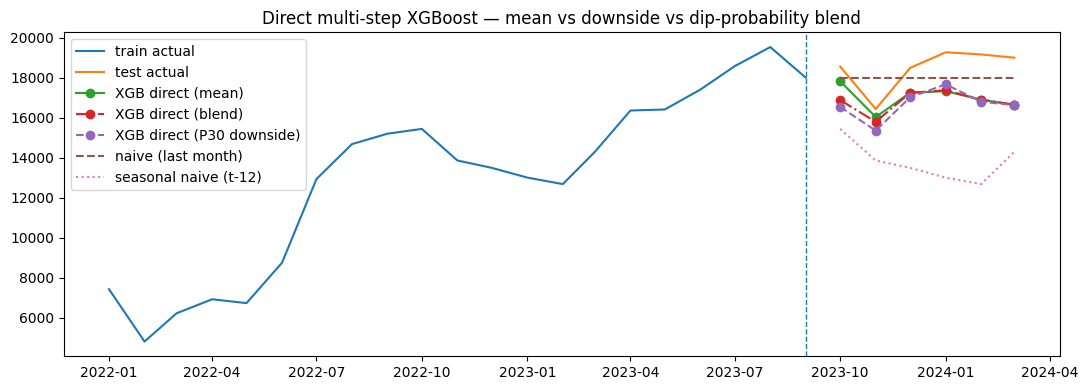


Dip probabilities on holdout (higher => model thinks a dip is more likely):
date
2023-10-01    0.821355
2023-11-01    0.577524
2023-12-01    0.350808
2024-01-01    0.436425
2024-02-01    0.238125
2024-03-01    0.233419
Freq: MS, Name: p_dip, dtype: float64


In [54]:
# === Direct multi-step XGBoost (h=1..H) with OPTIONAL EXOG + dip-probability blending ===
# Output: mean, downside (quantile if available), dip probability, and blended forecast.
# Blended = mean when dip-prob low; moves toward downside when dip-prob high.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor, XGBClassifier

assert "train_y" in globals() and "test_y" in globals(), "Define train_y and test_y first."

train_y = train_y.astype(float).copy()
test_y  = test_y.astype(float).copy()
train_y.index = pd.to_datetime(train_y.index)
test_y.index  = pd.to_datetime(test_y.index)
H = len(test_y)

# -----------------------------
# OPTIONAL: exog_full
# -----------------------------
use_exog = ("exog_full" in globals()) and (exog_full is not None)
if use_exog:
    exog_full = exog_full.copy()
    exog_full.index = pd.to_datetime(exog_full.index)
    all_idx = train_y.index.union(test_y.index)
    missing = all_idx.difference(exog_full.index)
    assert len(missing) == 0, f"exog_full missing months (count={len(missing)})."

    # Put ONLY truly known-in-advance (t+h) columns here if it is really known them at forecast time.
    KNOWN_FUTURE = [c for c in exog_full.columns if c.lower() in {
        "planned_spend", "marketing_spend_planned", "campaign_flag", "promo_flag",
        "holiday_flag", "regulation_flag"
    }]
else:
    exog_full = None
    KNOWN_FUTURE = []
    print("exog_full not found -> AR-only. Dip capture needs real drivers or more history.")

# -----------------------------
# Config
# -----------------------------
LAGS_Y   = (1, 2, 3, 6)
ROLLS_Y  = (3, 6)

EXOG_LAGS = (1, 3)     # keep small on tiny data
EXOG_ROLL = (3,)

# Blending behavior
P_DIP_THRESHOLD = 0.35   # if dip-prob <= threshold -> mostly mean
P_DIP_MAX       = 0.85   # cap dip-prob so we don't overreact
ALPHA_QUANTILE  = 0.30   # downside quantile; try 0.30–0.40 for better recovery than 0.20

# Models
reg_params = dict(
    n_estimators=1200,
    max_depth=4,
    learning_rate=0.02,
    subsample=0.85,
    colsample_bytree=0.9,
    min_child_weight=2.5,
    reg_alpha=0.1,
    reg_lambda=4.0,
    n_jobs=-1,
    tree_method="hist",
    random_state=42,
)

clf_params = dict(
    n_estimators=800,
    max_depth=3,
    learning_rate=0.03,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=2.0,
    n_jobs=-1,
    tree_method="hist",
    random_state=42,
)

# -----------------------------
# Feature builders
# -----------------------------
def _safe_numeric(df: pd.DataFrame) -> pd.DataFrame:
    df = df.apply(pd.to_numeric, errors="coerce")
    df = df.replace([np.inf, -np.inf], np.nan)
    return df

def make_origin_features(y: pd.Series, exog: pd.DataFrame | None):
    y = y.sort_index()
    logy  = np.log1p(y)
    dlogy = logy.diff()

    X = pd.DataFrame(index=y.index)
    X["log_level_t"] = logy

    for L in LAGS_Y:
        X[f"dlag_{L}"] = dlogy.shift(L-1)
    for r in ROLLS_Y:
        X[f"droll_mean_{r}"] = dlogy.rolling(r).mean()
        X[f"droll_std_{r}"]  = dlogy.rolling(r).std()

    m = X.index.month.astype(float)
    X["month_sin_t"] = np.sin(2*np.pi*m/12.0)
    X["month_cos_t"] = np.cos(2*np.pi*m/12.0)
    X["t_index"] = np.arange(len(X), dtype=float)

    if exog is not None:
        ex = _safe_numeric(exog.reindex(y.index)).ffill()
        for c in ex.columns:
            for L in EXOG_LAGS:
                X[f"{c}_lag{L}"] = ex[c].shift(L)
            X[f"{c}_diff1"] = ex[c] - ex[c].shift(1)
            for r in EXOG_ROLL:
                X[f"{c}_rm{r}"] = ex[c].rolling(r).mean()

    return X, logy, dlogy

def add_target_calendar(X: pd.DataFrame, h: int) -> pd.DataFrame:
    future_idx = X.index + pd.DateOffset(months=h)
    m = future_idx.month.astype(float)
    X2 = X.copy()
    X2[f"month_sin_h{h}"] = np.sin(2*np.pi*m/12.0)
    X2[f"month_cos_h{h}"] = np.cos(2*np.pi*m/12.0)
    return X2

def add_known_future_exog(X: pd.DataFrame, exog_full: pd.DataFrame | None, h: int, known_cols: list[str]) -> pd.DataFrame:
    if exog_full is None or not known_cols:
        return X
    future_idx = X.index + pd.DateOffset(months=h)
    ex = _safe_numeric(exog_full.reindex(future_idx)[known_cols]).ffill()
    ex.index = X.index
    X2 = X.copy()
    for c in known_cols:
        X2[f"{c}_tplus{h}"] = ex[c]
    return X2

# -----------------------------
# Train per-horizon: mean reg + downside reg (optional) + dip classifier
# -----------------------------
X_base, logy, dlogy = make_origin_features(train_y, exog_full)

mean_models, mean_cols = {}, {}
q_models, q_cols = {}, {}
clf_models, clf_cols = {}, {}

quantile_supported = True

for h in range(1, H+1):
    y_level = logy.shift(-h).rename("target_log_level")
    future_dlog = dlogy.shift(-h).rename("future_dlog")
    dip_label = (future_dlog < 0).astype(int).rename("is_dip")

    Xh = add_target_calendar(X_base, h)
    Xh = add_known_future_exog(Xh, exog_full, h, KNOWN_FUTURE)

    df = pd.concat([Xh, y_level, dip_label], axis=1).dropna()

    Xmat = df.drop(columns=["target_log_level", "is_dip"])
    yreg = df["target_log_level"].values
    yclf = df["is_dip"].values

    # ---- mean regressor ----
    reg = XGBRegressor(**reg_params, objective="reg:squarederror")
    reg.fit(Xmat, yreg)
    mean_models[h] = reg
    mean_cols[h] = list(Xmat.columns)

    # ---- downside regressor (quantile if available; else fallback to mean) ----
    if quantile_supported:
        try:
            reg_q = XGBRegressor(
                **reg_params,
                objective="reg:quantileerror",
                quantile_alpha=float(ALPHA_QUANTILE),
            )
            reg_q.fit(Xmat, yreg)
            q_models[h] = reg_q
            q_cols[h] = list(Xmat.columns)
        except Exception:
            quantile_supported = False

    # ---- dip classifier ----
    # basic imbalance handling: scale_pos_weight
    pos = float((yclf == 1).sum())
    neg = float((yclf == 0).sum())
    spw = (neg / pos) if pos > 0 else 1.0

    clf = XGBClassifier(**clf_params, objective="binary:logistic", eval_metric="logloss", scale_pos_weight=spw)
    clf.fit(Xmat, yclf)
    clf_models[h] = clf
    clf_cols[h] = list(Xmat.columns)

# -----------------------------
# Forecast from last train month t0
# -----------------------------
t0 = train_y.index.max()
X_base_t0, _, _ = make_origin_features(train_y, exog_full)
X_t0 = X_base_t0.loc[[t0]]

pred_idx = [t0 + pd.DateOffset(months=h) for h in range(1, H+1)]

pred_mean, pred_down, pred_pdip, pred_blend = [], [], [], []

for h in range(1, H+1):
    Xh = add_target_calendar(X_t0, h)
    Xh = add_known_future_exog(Xh, exog_full, h, KNOWN_FUTURE)

    X_mean = Xh.reindex(columns=mean_cols[h])
    log_mean = float(mean_models[h].predict(X_mean)[0])

    # dip probability
    X_clf = Xh.reindex(columns=clf_cols[h])
    pdip = float(clf_models[h].predict_proba(X_clf)[0, 1])
    pdip = float(np.clip(pdip, 0.0, P_DIP_MAX))

    # downside
    if quantile_supported and (h in q_models):
        X_q = Xh.reindex(columns=q_cols[h])
        log_down = float(q_models[h].predict(X_q)[0])
    else:
        log_down = log_mean  # fallback

    # blend: mostly mean unless dip probability high
    # use a smooth ramp after threshold
    if pdip <= P_DIP_THRESHOLD:
        w = 0.0
    else:
        w = (pdip - P_DIP_THRESHOLD) / (1.0 - P_DIP_THRESHOLD)
        w = float(np.clip(w, 0.0, 1.0))

    log_blend = (1.0 - w) * log_mean + w * log_down

    pred_mean.append(float(np.expm1(log_mean)))
    pred_down.append(float(np.expm1(log_down)))
    pred_pdip.append(pdip)
    pred_blend.append(float(np.expm1(log_blend)))

s_mean  = pd.Series(pred_mean,  index=pd.DatetimeIndex(pred_idx), name="mean").reindex(test_y.index)
s_down  = pd.Series(pred_down,  index=pd.DatetimeIndex(pred_idx), name="downside").reindex(test_y.index)
s_blend = pd.Series(pred_blend, index=pd.DatetimeIndex(pred_idx), name="blend").reindex(test_y.index)
s_pdip  = pd.Series(pred_pdip,  index=pd.DatetimeIndex(pred_idx), name="p_dip").reindex(test_y.index)

# -----------------------------
# Baselines
# -----------------------------
pred_naive = pd.Series(train_y.iloc[-1], index=test_y.index, name="naive")
seasonal_src = test_y.index - pd.DateOffset(months=12)
pred_seasonal = train_y.reindex(seasonal_src)
pred_seasonal.index = test_y.index
pred_seasonal.name = "seasonal_naive"


print("Holdout metrics:")
print("XGB direct (mean) :", fold_metrics(test_y, s_mean,  train_y))
print("XGB direct (blend):", fold_metrics(test_y, s_blend, train_y))
if quantile_supported:
    print(f"XGB direct (P{int(ALPHA_QUANTILE*100)}):", fold_metrics(test_y, s_down, train_y))
print("Naive             :", fold_metrics(test_y, pred_naive, train_y))
if not pred_seasonal.isna().any():
    print("Seasonal naive     :", fold_metrics(test_y, pred_seasonal, train_y))

# -----------------------------
# Plot
# -----------------------------
plt.figure(figsize=(11, 4))
plt.plot(train_y.index, train_y.values, label="train actual")
plt.plot(test_y.index,  test_y.values,  label="test actual")

plt.plot(s_mean.index,  s_mean.values,  marker="o", label="XGB direct (mean)")
plt.plot(s_blend.index, s_blend.values, marker="o", linestyle="-.", label="XGB direct (blend)")
if quantile_supported:
    plt.plot(s_down.index, s_down.values, marker="o", linestyle="--",
             label=f"XGB direct (P{int(ALPHA_QUANTILE*100)} downside)")

plt.plot(pred_naive.index, pred_naive.values, linestyle="--", label="naive (last month)")
if not pred_seasonal.isna().any():
    plt.plot(pred_seasonal.index, pred_seasonal.values, linestyle=":", label="seasonal naive (t-12)")

plt.axvline(train_y.index.max(), linestyle="--", linewidth=1)
plt.title("Direct multi-step XGBoost — mean vs downside vs dip-probability blend")
plt.legend()
plt.tight_layout()
plt.show()

print("\nDip probabilities on holdout (higher => model thinks a dip is more likely):")
print(s_pdip)


#### Notes on Interpretation

**1. This method needs enough "dip examples"**

The classifier and quantile model only learn dip behavior if there are enough negative-change months in training. With a short series:

- Dip probability becomes noisy or overly conservative
- Downside quantile can collapse to a flat line
- Blend tends not to improve point accuracy

**2. Dips are typically event-driven**

If the dip is driven by factors not represented in `exog_full` (campaign pause, affiliate mix shift, payout incident, ops disruption, regulation change), the model still sees it as a shock.

**3. One-shot multi-month forecasting cannot "recover" after observing the dip**

In real operations, re-forecast each month:

- Once the dip is observed, the next forecast updates and rebound timing improves
- A single $t_0 \to t+6$ run cannot incorporate that new evidence mid-horizon

#### Practical Takeaway (Links to the Main Discussion)

Even after trying direct multi-step + risk-aware blending, the main conclusion stays the same:

- These models are broadly similar on this dataset
- The key limitation is short history + lack of leading drivers
- The best improvement path is adding **exogenous drivers** (FTD/users/registrations, affiliate mix, campaign calendar, payout incidents, product/regulation flags) and/or increasing data volume (more months, more related series)

#### Summary

**Observed result:**

- The direct mean forecast remains the strongest point forecast
- Downside/blend variants can visualize "dip risk," but do not reliably improve overall accuracy

**Rolling CV + Optuna note:**

I tested rolling CV + hyperparameter tuning (not shown). On this dataset it often flattened predictions and worsened accuracy, which is expected when:

- Folds are tiny (high metric variance)
- Lag features reduce usable rows further
- Dip events are rare (unstable objective)

#### This Should Become Genuinely Useful

This regressor+classifier mixture becomes much more valuable as other modeling tasks:

- Longer history and more dip events
- Multiple related series (brands/markets/segments) to learn shared dip patterns
- Real driver data that precedes dips (planned spend, campaign calendar, affiliate changes, payouts/incidents, user funnels)

In that setting:

- Quantiles become meaningful (calibrated risk bands)
- Dip probability becomes actionable (early warning)
- Rolling CV and tuning become helpful because folds contain enough signal

#### Broad Applicable (e.g., Churn/CLV/Revenue Risk)

The same "predict amount + predict risk + blend" concept is useful in many business problems:

- **Churn:** predict churn probability (classifier) + revenue/usage impact (regressor)
- **CLV:** predict expected value (regressor) + probability of early drop-off/downshift (classifier)
- **Credit/default risk:** expected loss (regressor) + event probability (classifier)
- **Demand/revenue forecasting:** base forecast + downside scenario triggered by risk signals



#### Summary

**Observed result on this dataset:**

- The direct mean forecast remains the strongest point forecast
- The downside/blend variants can show "dip risk," but do not reliably improve overall accuracy
- Rolling CV + Optuna did not improve (often worsened), which is expected with:
  - Few samples
  - Many derived lag features (reducing usable rows)
  - Very few dip events (unstable objective)

**Why rolling CV/Optuna didn't help (important note):**

On very small time series:
- CV folds are tiny → high variance in metrics
- Hyperparameter search tends to "regularize" toward conservative predictions → flatter forecasts
- Tuning can easily overfit fold noise

**What would change with more time and data:**

If we had more history and/or multiple related series (brands/markets) + real EXOG drivers:
- Direct multi-step remains a good setup
- Dip classifier + quantile can become meaningful
- CV/Optuna becomes useful (because folds have enough signal)
- But the main conclusions would still match the main discussion: dips are best handled by drivers + regime awareness + frequent re-forecasting, not by swapping SARIMAX/LSTM/XGB alone